### Ensemble real trading model
1. Data collection: All A stocks.
2. Data cleaning: Clear inappropriate stocks like ST, ST* etc.
3. Label making: VWAP ROI of between T and T + 11.
4. Data preprocessing: 3MAD, z-score etc.
5. ROI dataframe making: HS300, CS500, CS1000 etc.
6. Modeling: MLP, GBDT, AGRU.
7. Ensembling: according to past 60 days' ICIR.
8. Backtesting.

Time consumption:
1. begin_date = '20210101', end_date = '20240225': about 1 + 1 + 2 = 4h

In [1]:
# Modeling
import tensorflow as tf
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Attention, Layer, GRU, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from math import sqrt
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import date, timedelta

from cylib.apis.all_api import *

# Suppress the warning
warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)

zscore = StandardScaler()

# Suppress the warning
# warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
Main_bactest = True
Online = True
path = "/home/huh/"

2024-05-11 00:38:51.949273: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-11 00:38:52.356993: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-11 00:38:52.358765: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 00:38:55.820606: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import psutil
import os

# Get the current process ID of the IPython kernel
pid = os.getpid()

# Get the process associated with the IPython kernel
process = psutil.Process(pid)

# Get the memory usage of the IPython kernel in MB
ram_usage = process.memory_info().rss / (1024 * 1024)

# Get the CPU usage percentage of the IPython kernel
cpu_usage = psutil.cpu_percent()

print(f"RAM Usage: {ram_usage} MB")
print(f"CPU Usage: {cpu_usage}%")

RAM Usage: 525.78515625 MB
CPU Usage: 16.5%


In [113]:
def RAM_USAGE():
    # Get the memory usage of the IPython kernel in MB
    ram_usage = process.memory_info().rss / (1024 * 1024)

    # Get the CPU usage percentage of the IPython kernel
    cpu_usage = psutil.cpu_percent()

    print(f"RAM Usage: {ram_usage} MB")
    print(f"CPU Usage: {cpu_usage}%")

### Remove inappropriate stocks.

In [3]:
# Remove inappropriate stocks.
begin_date = "20180101"
end_date = "20180601"
today_date = str(date.today())
if Main_bactest:
    end_date = today_date
all_stocks = get_targets_info(target_type="stock")
all_stocks.to_csv(path + 'all_stocks.csv', index=False)

all_stocks = all_stocks[["ts_code", "name", "industry", "list_status", "list_date", "exchange"]]
all_stocks["list_date"] = pd.to_datetime(all_stocks["list_date"])

# Remove stocks before begin date.
all_stocks = all_stocks[all_stocks["list_date"] <= pd.to_datetime(begin_date)]
all_stocks = all_stocks[all_stocks["list_status"] == "L"]  # Remove unlisted stocks.
all_stocks = all_stocks[all_stocks["exchange"] != "BSE"]
# all_stocks = all_stocks[~all_stocks["name"].str.endswith("(IPO终止)")]
all_stocks = all_stocks[~all_stocks["name"].str.startswith("ST")]  # Remove ST
all_stocks = all_stocks[~all_stocks["name"].str.startswith("*ST")]  # Remove *ST
all_stocks.reset_index(drop=True, inplace=True)

# Remove '000792.SZ' and '000670.SZ' as they have missing values.
# mask = all_stocks['ts_code'].isin(['000792.SZ', '000670.SZ'])
# new_df = all_stocks[mask]
# removing the filtered rows from the original dataframe
# all_stocks = all_stocks[~mask]

stocks_code = list(all_stocks["ts_code"])
# stocks_code

In [4]:
all_stocks

,ts_code,name,industry,list_status,list_date,exchange
0,000001.SZ,平安银行,银行,L,1991-04-03,SZSE
1,000002.SZ,万科A,全国地产,L,1991-01-29,SZSE
2,000004.SZ,国华网安,软件服务,L,1991-01-14,SZSE
3,000006.SZ,深振业A,区域地产,L,1992-04-27,SZSE
4,000008.SZ,神州高铁,运输设备,L,1992-05-07,SZSE
...,...,...,...,...,...,...
3148,603991.SH,至正股份,塑料,L,2017-03-08,SSE
3149,603993.SH,洛阳钼业,小金属,L,2012-10-09,SSE
3150,603997.SH,继峰股份,汽车配件,L,2015-03-02,SSE
3151,603998.SH,方盛制药,中成药,L,2014-12-05,SSE


In [5]:
len(stocks_code)

3153

In [6]:
# stock_code_path = 'stock_code.pkl'

# with open(path + stock_code_path, 'rb') as file:
#     stocks_code = pickle.load(file)
# stocks_code

### Trade date
- Train date
- Test date
- Backtest date
- Drop date: Date of stocks which don't have labels
- GRU(AGRU) date: Date for GRU(AGRU) model

In [7]:
PRICE = get_price(
    ts_code_list=stocks_code,
    feature_list=["open"],
    start_date=begin_date,
    trade_date=end_date,
    target_type="stock",
)
PRICE.reset_index(inplace=True)
PRICE = PRICE.sort_values(by="trade_date").reset_index(drop=True)
# price.set_index(['trade_date', 'ts_code'], inplace=True)
PRICE_pivot = PRICE.fillna(0)
PRICE_pivot = PRICE_pivot.pivot(index="trade_date", columns="ts_code", values="open")

# Attention: len(date_all) >= 60
date_all = PRICE_pivot.index
date_train, date_backtest = train_test_split(date_all, test_size=0.2, shuffle=False)
date_test = date_backtest[:-11]
date_drop = date_backtest[-11:]
date_GRU = date_all[29:]

# Find missing stocks
all_combinations = pd.MultiIndex.from_product(
    [date_all, stocks_code], names=["trade_date", "ts_code"]
)
all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
price_whole = pd.merge(
    all_combinations_df, PRICE, on=["trade_date", "ts_code"], how="left"
)
missing = price_whole[price_whole.isnull().any(axis=1)]
missing_stock = missing["ts_code"].unique()
print("The missing stock:", missing_stock)

# Remove the stocks cause they have missing values.
mask = all_stocks["ts_code"].isin(missing_stock)
# new_df = all_stocks[mask]
# removing the filtered rows from the original dataframe
all_stocks = all_stocks[~mask]
stocks_code = list(all_stocks["ts_code"])

# Del variables to release RAM.
del (
    PRICE,
    PRICE_pivot,
    all_combinations,
    all_combinations_df,
    price_whole,
    missing,
    missing_stock,
)

The missing stock: ['000629.SZ' '000950.SZ' '000995.SZ' '600610.SH' '000670.SZ' '000792.SZ']


In [8]:
if Main_bactest:
    date_all_df = pd.DataFrame({'trade_date': date_all})
    date_all_df.to_csv(path + 'date_all_df.csv', index=False)

In [9]:
if not Online:
    date_all_df = pd.read_csv(path + 'date_all_df.csv',
                            parse_dates=['trade_date'],
                            index_col='trade_date')

    date_all = date_all_df.index
    date_train, date_backtest = train_test_split(date_all, test_size=0.2, shuffle=False)
    date_test = date_backtest[:-11]
    date_drop = date_backtest[-11:]
    date_GRU = date_all[29:]

In [10]:
# Get the memory usage of the IPython kernel in MB
ram_usage = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage: {ram_usage} MB")

RAM Usage: 561.75 MB


In [11]:
print(date_train)

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-15',
               ...
               '2023-01-12', '2023-01-13', '2023-01-16', '2023-01-17',
               '2023-01-18', '2023-01-19', '2023-01-20', '2023-01-30',
               '2023-01-31', '2023-02-01'],
              dtype='datetime64[ns]', name='trade_date', length=1232, freq=None)


In [12]:
print(date_test)

DatetimeIndex(['2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07',
               '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-13',
               '2023-02-14', '2023-02-15',
               ...
               '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12',
               '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18',
               '2024-04-19', '2024-04-22'],
              dtype='datetime64[ns]', name='trade_date', length=297, freq=None)


In [13]:
print(date_backtest)

DatetimeIndex(['2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07',
               '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-13',
               '2023-02-14', '2023-02-15',
               ...
               '2024-04-24', '2024-04-25', '2024-04-26', '2024-04-29',
               '2024-04-30', '2024-05-06', '2024-05-07', '2024-05-08',
               '2024-05-09', '2024-05-10'],
              dtype='datetime64[ns]', name='trade_date', length=308, freq=None)


In [14]:
print(date_drop)

DatetimeIndex(['2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26',
               '2024-04-29', '2024-04-30', '2024-05-06', '2024-05-07',
               '2024-05-08', '2024-05-09', '2024-05-10'],
              dtype='datetime64[ns]', name='trade_date', freq=None)


In [15]:
print(date_GRU)

DatetimeIndex(['2018-02-12', '2018-02-13', '2018-02-14', '2018-02-22',
               '2018-02-23', '2018-02-26', '2018-02-27', '2018-02-28',
               '2018-03-01', '2018-03-02',
               ...
               '2024-04-24', '2024-04-25', '2024-04-26', '2024-04-29',
               '2024-04-30', '2024-05-06', '2024-05-07', '2024-05-08',
               '2024-05-09', '2024-05-10'],
              dtype='datetime64[ns]', name='trade_date', length=1511, freq=None)


### Get stocks

In [16]:
# Get stocks
price = get_price(
    ts_code_list=stocks_code,
    feature_list=[
        "open",
        "high",
        "low",
        "close",
        "avg_price",
        "volume",
        "trade_status",  # "交易"/"停牌"
    ],
    start_date=begin_date,
    trade_date=end_date,
    target_type="stock",
)
price = price.rename(
    columns={
        "open": "OPEN",
        "high": "HIGH",
        "low": "LOW",
        "close": "CLOSE",
        "avg_price": "VWAP",
        "volume": "VOLUME",
    }
)
price.reset_index(inplace=True)
indexes = ["OPEN", "HIGH", "LOW", "CLOSE", "VWAP", "VOLUME"]
# Add weekend, If it is Monday, the value is 1, or 0.
# price['Monday'] = (price['trade_date'].dt.dayofweek == 0).astype(int)
price = price.sort_values(by="trade_date").reset_index(drop=True)
# price.set_index(['trade_date', 'ts_code'], inplace=True)
# price.fillna(0, inplace=True)
price

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,trade_status
0,2018-01-02,000001.SZ,13.35,13.93,13.32,13.70,13.7229,2081590.0,交易
1,2018-01-02,601113.SH,14.41,14.58,14.18,14.47,14.4399,18480.7,交易
2,2018-01-02,002156.SZ,13.25,13.47,13.04,13.42,13.2816,259075.0,交易
3,2018-01-02,601116.SH,20.94,21.14,20.73,20.95,20.8979,38405.7,交易
4,2018-01-02,002155.SZ,9.77,9.78,9.63,9.70,9.6832,178833.0,交易
...,...,...,...,...,...,...,...,...,...
4846375,2024-05-10,603129.SH,154.05,161.80,150.80,160.30,157.2340,23840.6,交易
4846376,2024-05-10,600706.SH,11.84,12.68,11.84,12.37,12.3907,251045.0,交易
4846377,2024-05-10,002416.SZ,11.56,11.58,11.17,11.29,11.3008,87571.7,交易
4846378,2024-05-10,000890.SZ,3.55,3.56,3.45,3.46,3.4794,83575.1,交易


In [17]:
# Get the memory usage of the IPython kernel in MB
ram_usage = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage: {ram_usage} MB")

RAM Usage: 3292.19921875 MB


In [18]:
# all_combinations = pd.MultiIndex.from_product([date_all, stocks_code], names=['trade_date', 'ts_code'])
# all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
# price_whole = pd.merge(all_combinations_df, price, on=['trade_date', 'ts_code'], how='left')

# price.fillna(0, inplace=True)
# del all_combinations, all_combinations_df

In [19]:
# missing = price_whole[price_whole.isnull().any(axis=1)]
# missing['trade_status'].fillna('停牌', inplace=True)
# missing.reset_index(drop=True, inplace=True)
# missing.set_index(['trade_date'], inplace=True)
# missing

In [20]:
# missing_stock = missing['ts_code'].unique()
# print(missing_stock)

In [21]:
# pivot_price_whole = price_whole.pivot(
#     index="trade_date",
#     columns="ts_code",
#     values=["OPEN", "HIGH", "LOW", "CLOSE", "VWAP", "VOLUME"],
# )
# # Swap levels of column multi-index
# pivot_price_whole.columns = pivot_price_whole.columns.swaplevel(0, 1)
# pivot_price_whole.sort_index(axis=1, level=0, inplace=True)
# pivot_price_whole.fillna(method='ffill', inplace=True)
# pivot_price_whole[missing_stock]
# pivot_price_whole

Here's an explanation of the code provided:

1. **Pivoting the DataFrame**: The `pivot()` function is used on the `price` DataFrame to pivot the data. By specifying `index='trade_date'` and `columns='ts_code'`, the DataFrame is reshaped so that the unique values in the 'ts_code' column become the main columns.

2. **Swapping Column Levels**: After pivoting, the column index becomes a MultiIndex with levels for 'OPEN' and 'LOW'. The `swaplevel(0, 1)` method swaps these levels so that the stock codes are the outer level and 'OPEN'/'LOW' are the inner level.

3. **Sorting the Columns**: The `sort_index()` method is used to sort the columns based on the outer level (stock codes) to match your requirement of having stock codes as the main columns and OPEN/LOW as sub-columns under each stock code.

This process effectively reshapes the DataFrame to meet your specific requirements for organizing the data by stock codes and price types.

In [22]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846380 entries, 0 to 4846379
Data columns (total 9 columns):
 #   Column        Dtype         
---  ------        -----         
 0   trade_date    datetime64[ns]
 1   ts_code       object        
 2   OPEN          float64       
 3   HIGH          float64       
 4   LOW           float64       
 5   CLOSE         float64       
 6   VWAP          float64       
 7   VOLUME        float64       
 8   trade_status  object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 332.8+ MB


### Get benchmark index
$ \textcolor{red}{Buy \ at \ today's \ open \ and \ sell \ at \ today's\ close.\ (Just\ a \ suppose.)} $

In [23]:
# Get benchmark index
# 1. the Shanghai and Shenzhen 300 index(the HS 300 index)(000300)
# 2. the China Securities 500 index(000905)
# 3. the China Securities 1000 index(000852)
benchmark = get_price(
    ts_code_list=["000300.SH", "000905.SH", "000852.SH"],
    feature_list=["open", "high", "low", "close", "volume"],
    start_date=begin_date,
    trade_date=end_date,
    target_type="index",
)
benchmark = benchmark.rename(
    columns={
        "open": "OPEN",
        "high": "HIGH",
        "low": "LOW",
        "close": "CLOSE",
        "volume": "VOLUME",
    }
)
benchmark.reset_index(inplace=True)
# Add weekend, If it is Monday, the value is 1, or 0.
# benchmark["Monday"] = (benchmark["trade_date"].dt.dayofweek == 0).astype(int)
benchmark = benchmark.sort_values(by="trade_date").reset_index(drop=True)
benchmark.fillna(0, inplace=True)
benchmark

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VOLUME
0,2018-01-02,000300.SH,4045.21,4087.78,4045.21,4087.40,146935000.0
1,2018-01-02,000905.SH,6263.15,6332.61,6258.16,6332.23,73032200.0
2,2018-01-02,000852.SH,7027.63,7092.22,7022.23,7092.09,77191000.0
3,2018-01-03,000300.SH,4091.46,4140.05,4088.73,4111.39,151852000.0
4,2018-01-03,000905.SH,6331.72,6391.98,6324.26,6388.25,83936700.0
...,...,...,...,...,...,...,...
4612,2024-05-09,000905.SH,5461.36,5568.73,5461.36,5556.77,131121000.0
4613,2024-05-09,000852.SH,5533.51,5638.64,5533.51,5626.83,172678000.0
4614,2024-05-10,000300.SH,3669.09,3674.61,3641.76,3666.28,150721000.0
4615,2024-05-10,000852.SH,5632.76,5641.92,5549.61,5574.23,188377000.0


In [24]:
if Main_bactest:
    benchmark.to_csv("benchmark.csv", index=False)

In [25]:
if not Online:
    benchmark = pd.read_csv(path + "benchmark.csv", parse_dates=["trade_date"])

### Get daily return DataFrame

In [26]:
BUY_price = price.pivot(index="trade_date", columns="ts_code", values="OPEN")
BUY_benchmark = benchmark.pivot(index="trade_date", columns="ts_code", values="OPEN")
SELL_price = price.pivot(index="trade_date", columns="ts_code", values="CLOSE")
SELL_benchmark = benchmark.pivot(index="trade_date", columns="ts_code", values="CLOSE")
price_return = (SELL_price - BUY_price) / BUY_price
benchmark_return = (SELL_benchmark - BUY_benchmark) / BUY_benchmark

del BUY_price, BUY_benchmark, SELL_price, SELL_benchmark

In [27]:
if Main_bactest:
    price_return.to_csv('price_return.csv')
    benchmark_return.to_csv('benchmark_return.csv')

In [28]:
if not Online:
    price_return = pd.read_csv(
        path + "price_return.csv", parse_dates=["trade_date"], index_col="trade_date")
    benchmark_return = pd.read_csv(
        path + "benchmark_return.csv", parse_dates=["trade_date"], index_col="trade_date")

In [29]:
HS_300 = pd.DataFrame(benchmark_return["000300.SH"])
CS_500 = pd.DataFrame(benchmark_return["000905.SH"])
CS_1000 = pd.DataFrame(benchmark_return["000852.SH"])

In [30]:
ram_usage = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage: {ram_usage} MB")

RAM Usage: 3333.07421875 MB


### Make predicting label

In [31]:
# Make predicting label

# T+1 to T+11 VWAP return
VWAP_df = price.pivot(index="trade_date", columns="ts_code", values="VWAP")
# VWAP_df.rolling()

# the change rate of T+1 to T+11
T_begin = 1
T_end = 11
Label_df = (VWAP_df.shift(-T_end) - VWAP_df.shift(-T_begin)) / VWAP_df.shift(-T_begin)
# Attention! zscore.fit_transform() is calculated column by column, so we use Label_df.T
Label_df_processed = pd.DataFrame(
    zscore.fit_transform(Label_df.T).T, index=Label_df.index, columns=Label_df.columns
)
# trade_date = Label_df.index[: -11]

# Create a dictionary to map trade_date to the corresponding label values
label_dict = Label_df.to_dict(orient="index")
label_dict_processed = Label_df_processed.to_dict(orient="index")


# Define a function to get the label value for a given row (trade_date and stock code)
def get_label(row):
    return label_dict[row["trade_date"]][row["ts_code"]]


def get_label_processed(row):
    return label_dict_processed[row["trade_date"]][row["ts_code"]]


# Apply the function to create a new 'Label' column in the 'price' dataframe
Label_column = price.apply(get_label, axis=1)
price["Label"] = Label_column
Label_column_processed = price.apply(get_label_processed, axis=1)

del VWAP_df, Label_df, label_dict, label_dict_processed

/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count


### Data preprocessing

In [32]:
# Data preprocessing
def value_mapping(row):
    global value_dict
    return value_dict[row["trade_date"]][row["ts_code"]]

# 3MAD
def Col_3MAD(row):
    median = row.median()  # median
    mad = abs(row - row.median()).median()
    threshold = 3 * mad
    lower_bound = median - threshold
    upper_bound = median + threshold
    return row.clip(lower=lower_bound, upper=upper_bound)

indexes = ["OPEN", "HIGH", "LOW", "CLOSE", "VWAP", "VOLUME"]
for index in indexes:
    df = price.pivot(index="trade_date", columns="ts_code", values=index)
    values = df.values
    # Standardize for each row
    df = pd.DataFrame(
        zscore.fit_transform(values.T).T, index=df.index, columns=df.columns
    )
    df = df.apply(Col_3MAD, axis=1)  # 3 times MAD for each row
    value_dict = df.to_dict(orient="index")
    price[index + "_processed"] = price.apply(value_mapping, axis=1)
price["Label_processed"] = Label_column_processed
# It needs to be modified. It is possible to have nan values except for the last 11 days of the time
# Remove last 11 days' missing data. (T_end - T_begin + 1)
del Label_column, Label_column_processed
price.fillna(0, inplace=True)
price

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,trade_status,Label,OPEN_processed,HIGH_processed,LOW_processed,CLOSE_processed,VWAP_processed,VOLUME_processed,Label_processed
0,2018-01-02,000001.SZ,13.35,13.93,13.32,13.70,13.7229,2081590.0,交易,0.071596,-0.240679,-0.224266,-0.236120,-0.229259,-0.225786,0.001326,1.021076
1,2018-01-02,601113.SH,14.41,14.58,14.18,14.47,14.4399,18480.7,交易,-0.025521,-0.190703,-0.194065,-0.194851,-0.193079,-0.191951,-0.250194,-0.095807
2,2018-01-02,002156.SZ,13.25,13.47,13.04,13.42,13.2816,259075.0,交易,-0.127945,-0.245393,-0.245639,-0.249556,-0.242415,-0.246611,0.001326,-1.273724
3,2018-01-02,601116.SH,20.94,21.14,20.73,20.95,20.8979,38405.7,交易,-0.050040,0.117166,0.110729,0.119461,0.111396,0.112807,-0.195084,-0.377787
4,2018-01-02,002155.SZ,9.77,9.78,9.63,9.70,9.6832,178833.0,交易,0.002949,-0.409465,-0.417085,-0.413190,-0.417206,-0.416422,0.001326,0.231607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4846375,2024-05-10,603129.SH,154.05,161.80,150.80,160.30,157.2340,23840.6,交易,0.000000,0.208018,0.209431,0.203864,0.203242,0.203921,-0.549976,0.000000
4846376,2024-05-10,600706.SH,11.84,12.68,11.84,12.37,12.3907,251045.0,交易,0.000000,-0.053971,-0.035624,-0.046231,-0.035950,-0.036079,0.066896,0.000000
4846377,2024-05-10,002416.SZ,11.56,11.58,11.17,11.29,11.3008,87571.7,交易,0.000000,-0.061726,-0.065911,-0.065123,-0.066199,-0.066549,-0.376943,0.000000
4846378,2024-05-10,000890.SZ,3.55,3.56,3.45,3.46,3.4794,83575.1,交易,0.000000,-0.283559,-0.286736,-0.282793,-0.285506,-0.285213,-0.387794,0.000000


In [33]:
if Main_bactest:
    price.to_csv("price_processed.csv", index=False)

In [34]:
if not Online:
    price = pd.read_csv("price_processed.csv", parse_dates=["trade_date"])

In [35]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846380 entries, 0 to 4846379
Data columns (total 17 columns):
 #   Column            Dtype         
---  ------            -----         
 0   trade_date        datetime64[ns]
 1   ts_code           object        
 2   OPEN              float64       
 3   HIGH              float64       
 4   LOW               float64       
 5   CLOSE             float64       
 6   VWAP              float64       
 7   VOLUME            float64       
 8   trade_status      object        
 9   Label             float64       
 10  OPEN_processed    float64       
 11  HIGH_processed    float64       
 12  LOW_processed     float64       
 13  CLOSE_processed   float64       
 14  VWAP_processed    float64       
 15  VOLUME_processed  float64       
 16  Label_processed   float64       
dtypes: datetime64[ns](1), float64(14), object(2)
memory usage: 628.6+ MB


In [36]:
ram_usage = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage: {ram_usage} MB")

RAM Usage: 4148.87890625 MB


### Data spliting

In [37]:
# date_train, date_test = train_test_split(trade_date, test_size=0.2, shuffle=False)
price_train = price.loc[price["trade_date"].isin(date_train), :]
date_stock = ["trade_date", "ts_code"]
X_indexes = [
    "OPEN_processed",
    "HIGH_processed",
    "LOW_processed",
    "CLOSE_processed",
    "VWAP_processed",
    "VOLUME_processed",
]
y_index = "Label_processed"
price_X_train = price_train[X_indexes].values
price_y_train = price_train[y_index].values
del price_train

In [38]:
np.isnan(price_y_train).any()

False

In [39]:
np.isnan(price_X_train).any()

False

In [40]:
price_test = price.loc[price["trade_date"].isin(date_test), :]
price_X_test = price_test[X_indexes].values
price_y_test = price_test[y_index].values
del price_test

In [41]:
price_drop = price.loc[price["trade_date"].isin(date_drop), :]
price_X_drop = price_drop[X_indexes].values
price_y_drop = price_drop[y_index].values
del price_drop

In [42]:
price_X_backtest = np.concatenate((price_X_test, price_X_drop), axis=0)

In [43]:
price_X_all = price[X_indexes].values
price_y_all = price[y_index].values

In [44]:
ram_usage = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage: {ram_usage} MB")

RAM Usage: 5136.28515625 MB


In [45]:
price

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,trade_status,Label,OPEN_processed,HIGH_processed,LOW_processed,CLOSE_processed,VWAP_processed,VOLUME_processed,Label_processed
0,2018-01-02,000001.SZ,13.35,13.93,13.32,13.70,13.7229,2081590.0,交易,0.071596,-0.240679,-0.224266,-0.236120,-0.229259,-0.225786,0.001326,1.021076
1,2018-01-02,601113.SH,14.41,14.58,14.18,14.47,14.4399,18480.7,交易,-0.025521,-0.190703,-0.194065,-0.194851,-0.193079,-0.191951,-0.250194,-0.095807
2,2018-01-02,002156.SZ,13.25,13.47,13.04,13.42,13.2816,259075.0,交易,-0.127945,-0.245393,-0.245639,-0.249556,-0.242415,-0.246611,0.001326,-1.273724
3,2018-01-02,601116.SH,20.94,21.14,20.73,20.95,20.8979,38405.7,交易,-0.050040,0.117166,0.110729,0.119461,0.111396,0.112807,-0.195084,-0.377787
4,2018-01-02,002155.SZ,9.77,9.78,9.63,9.70,9.6832,178833.0,交易,0.002949,-0.409465,-0.417085,-0.413190,-0.417206,-0.416422,0.001326,0.231607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4846375,2024-05-10,603129.SH,154.05,161.80,150.80,160.30,157.2340,23840.6,交易,0.000000,0.208018,0.209431,0.203864,0.203242,0.203921,-0.549976,0.000000
4846376,2024-05-10,600706.SH,11.84,12.68,11.84,12.37,12.3907,251045.0,交易,0.000000,-0.053971,-0.035624,-0.046231,-0.035950,-0.036079,0.066896,0.000000
4846377,2024-05-10,002416.SZ,11.56,11.58,11.17,11.29,11.3008,87571.7,交易,0.000000,-0.061726,-0.065911,-0.065123,-0.066199,-0.066549,-0.376943,0.000000
4846378,2024-05-10,000890.SZ,3.55,3.56,3.45,3.46,3.4794,83575.1,交易,0.000000,-0.283559,-0.286736,-0.282793,-0.285506,-0.285213,-0.387794,0.000000


In [46]:
# price.groupby('trade_date')['ts_code'].nunique()

### Modeling

##### MLP

In [47]:
# Define the MLP model
model_MLP = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(1),
    ]
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_MLP.compile(optimizer=optimizer, loss="mean_squared_error")

# Train the model
early_stopping_MLP = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=50, restore_best_weights=True
)
history_MLP = model_MLP.fit(
    price_X_train,
    price_y_train,
    epochs=1000,
    callbacks=[early_stopping_MLP],
    validation_data=(price_X_test, price_y_test),
    batch_size=len(price_X_train),  # Set batch size as the training set size
)

# Evaluate the model
y_pred_MLP_backtest = model_MLP.predict(price_X_backtest)
y_pred_MLP_all = model_MLP.predict(price_X_all)
mse_MLP_train = mean_squared_error(price_y_train, model_MLP.predict(price_X_train))
mse_MLP_test = mean_squared_error(price_y_test, model_MLP.predict(price_X_test))

print(f"MLP MSE(train): {mse_MLP_train}")
print(f"MLP MSE(test): {mse_MLP_test}")
# MLP MSE(train): 0.9924953226659671
# MLP MSE(test): 0.9949950036401641

Epoch 1/1000


2024-05-11 00:56:07.037820: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1985077248 exceeds 10% of free system memory.
2024-05-11 00:56:07.037921: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1985077248 exceeds 10% of free system memory.
2024-05-11 00:56:07.038211: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1985077248 exceeds 10% of free system memory.
2024-05-11 00:56:07.753627: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 496269312 exceeds 10% of free system memory.
2024-05-11 00:56:07.790099: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 496269312 exceeds 10% of free system memory.


1/1 [==============================] - 11s 11s/step - loss: 1.0016 - val_loss: 0.9980
Epoch 2/1000
1/1 [==============================] - 9s 9s/step - loss: 0.9992 - val_loss: 0.9961
Epoch 3/1000
1/1 [==============================] - 9s 9s/step - loss: 0.9983 - val_loss: 0.9951
Epoch 4/1000
1/1 [==============================] - 9s 9s/step - loss: 0.9982 - val_loss: 0.9948
Epoch 5/1000
1/1 [==============================] - 10s 10s/step - loss: 0.9981 - val_loss: 0.9949
Epoch 6/1000
1/1 [==============================] - 9s 9s/step - loss: 0.9979 - val_loss: 0.9950
Epoch 7/1000
1/1 [==============================] - 10s 10s/step - loss: 0.9977 - val_loss: 0.9951
Epoch 8/1000
1/1 [==============================] - 10s 10s/step - loss: 0.9974 - val_loss: 0.9953
Epoch 9/1000
1/1 [==============================] - 9s 9s/step - loss: 0.9972 - val_loss: 0.9956
Epoch 10/1000
1/1 [==============================] - 10s 10s/step - loss: 0.9971 - val_loss: 0.9960
Epoch 11/1000
1/1 [=============

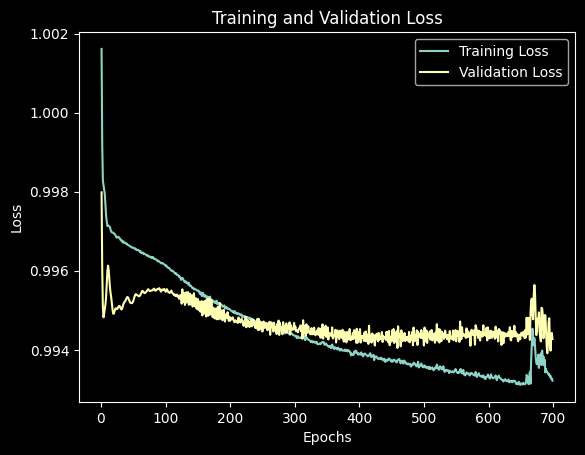

In [48]:
# Extract loss values from the history object
training_loss_MLP = history_MLP.history['loss']
validation_loss_MLP = history_MLP.history['val_loss']

# Create a range of epochs for x-axis
epochs = range(1, len(training_loss_MLP) + 1)

# Plot the training and validation loss values
plt.plot(epochs, training_loss_MLP, label='Training Loss')
plt.plot(epochs, validation_loss_MLP, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
# Save the numpy array to a file
if Main_bactest:
    np.save('y_pred_MLP_backtest.npy', y_pred_MLP_backtest)
    np.save('y_pred_MLP_all.npy', y_pred_MLP_all)

In [50]:
if not Online:
    y_pred_MLP_backtest = np.load("y_pred_MLP_backtest.npy")
    y_pred_MLP_all = np.load("y_pred_MLP_all.npy")

##### GBDT(XGboost)

In [51]:
params = {
    "learning_rate": 0.01,
    "max_depth": 64,
    "max_leaves": 512,
    "min_child_weight": 512,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "objective": "reg:squarederror",
}

dtrain = xgb.DMatrix(price_X_train, label=price_y_train)
dtest = xgb.DMatrix(price_X_test, label=price_y_test)
dbacktest = xgb.DMatrix(price_X_backtest)
dall = xgb.DMatrix(price_X_all)

evals = [(dtest, "eval"), (dtrain, "train")]
num_round = 200

# train_loss_GBDT = []
# val_loss_GBDT = []
# Define a callback function to monitor the training progress and capture loss data
# def callback(env):
#     iteration = env.iteration
#     train_rmse = env.evaluation_result_list[1][1]
#     val_rmse = env.evaluation_result_list[0][1]
#     train_loss_GBDT.append(train_rmse)
#     val_loss_GBDT.append(val_rmse)

bst = xgb.train(
    params, 
    dtrain, 
    num_round, 
    evals, 
    early_stopping_rounds=50, 
    verbose_eval=True
)

y_pred_GBDT_backtest = bst.predict(dbacktest)
y_pred_GBDT_all = bst.predict(dall)
mse_GBDT_train = mean_squared_error(price_y_train, bst.predict(dtrain))
mse_GBDT_test = mean_squared_error(price_y_test, bst.predict(dtest))

print(f"GBDT MSE(train): {mse_GBDT_train}")
print(f"GBDT MSE(test): {mse_GBDT_test}")
# GBDT MSE(train): 0.9476405621114625
# GBDT MSE(test): 1.002617615102808

/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-rmse:1.11584	train-rmse:1.11567
[1]	eval-rmse:1.11359	train-rmse:1.11334
[2]	eval-rmse:1.11141	train-rmse:1.11104
[3]	eval-rmse:1.10925	train-rmse:1.10877
[4]	eval-rmse:1.10713	train-rmse:1.10655
[5]	eval-rmse:1.10506	train-rmse:1.10437
[6]	eval-rmse:1.10303	train-rmse:1.10222
[7]	eval-rmse:1.10103	train-rmse:1.10012
[8]	eval-rmse:1.09908	train-rmse:1.09805
[9]	eval-rmse:1.09714	train-rmse:1.09602
[10]	eval-rmse:1.09523	train-rmse:1.09402
[11]	eval-rmse:1.09337	train-rmse:1.09206
[12]	eval-rmse:1.09162	train-rmse:1.09015
[13]	eval-rmse:1.08990	train-rmse:1.08826
[14]	eval-rmse:1.08814	train-rmse:1.08640
[15]	eval-rmse:1.08640	train-rmse:1.08457
[16]	eval-rmse:1.08471	train-rmse:1.08277
[17]	eval-rmse:1.08305	train-rmse:1.08101
[18]	eval-rmse:1.08142	train-rmse:1.07928
[19]	eval-rmse:1.07987	train-rmse:1.07759
[20]	eval-rmse:1.07830	train-rmse:1.07592
[21]	eval-rmse:1.07676	train-rmse:1.07428
[22]	eval-rmse:1.07524	train-rmse:1.07266
[23]	eval-rmse:1.07376	train-rmse:1.07108
[2

In [52]:
# Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(train_loss_GBDT, label='Training Loss')
# plt.plot(val_loss_GBDT, label='Validation Loss')
# plt.xlabel('Number of Iterations')
# plt.ylabel('Root Mean Squared Error (RMSE)')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

In [53]:
if Main_bactest:
    # Save the numpy array to a file
    np.save("y_pred_GBDT_backtest.npy", y_pred_GBDT_backtest)
    np.save("y_pred_GBDT_all.npy", y_pred_GBDT_all)

In [54]:
if not Online:
    y_pred_GBDT_backtest = np.load('y_pred_GBDT_backtest.npy')
    y_pred_GBDT_all = np.load('y_pred_GBDT_all.npy')

In [55]:
ram_usage = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage: {ram_usage} MB")

RAM Usage: 15120.03125 MB


##### Sequence preprocessing

In [56]:
from tqdm import tqdm  # For status process bar

# Create sequences of variable length for each stock
def create_sequences(df, sequence_length, begin_index, end_index):
    """
    sequence length: number of time steps in the entire sequence.
    In this paper, sequence length = 30.

    type: 'train' or 'test'

    begin index: index of the first sequence
    end index: index of the last sequence
    """
    sequences = []
    labels = []
    for stock in tqdm(df["ts_code"].unique(), desc="Stocks Progress", ncols=100):
        # Single stock dataframe
        stock_df = df[df["ts_code"] == stock].reset_index(drop=True)
        for i in range(sequence_length + begin_index, end_index + 2):
            # The last sequence is included.
            seq = stock_df.iloc[i - sequence_length : i][
                [
                    "OPEN_processed",
                    "HIGH_processed",
                    "LOW_processed",
                    "CLOSE_processed",
                    "VWAP_processed",
                    "VOLUME_processed",
                ]
            ].values
            label = stock_df.iloc[i - 1]["Label_processed"]
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels)


# Set the desired sequence length
sequence_length = 30

train_X, train_y = create_sequences(price, sequence_length, 0, len(date_train) - 1)
# Note: len(date_train) + len(date_test) is the length of Modeling date.
test_X, test_y = create_sequences(
    price,
    sequence_length,
    len(date_train) - sequence_length + 1,
    len(date_train) + len(date_test) - 1,
)
drop_X, drop_y = create_sequences(
    price,
    sequence_length,
    len(date_train) + len(date_test) - sequence_length + 1,
    len(date_all) - 1,
)

Stocks Progress: 100%|██████████████████████████████████████████| 3147/3147 [28:49<00:00,  1.82it/s]


In [57]:
print(train_X.shape)
print(test_X.shape)
print(drop_X.shape)

(3785841, 30, 6)
(934659, 30, 6)
(34617, 30, 6)


In [58]:
if Main_bactest:
    # # Save the numpy array to a file
    np.save("train_X.npy", train_X)
    np.save("train_y.npy", train_y)
    np.save("test_X.npy", test_X)
    np.save("test_y.npy", test_y)

# train_X = np.load('train_X.npy')
# train_y = np.load('train_y.npy')
# test_X = np.load('test_X.npy')
# test_y = np.load('test_y.npy')

In [59]:
ram_usage = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage: {ram_usage} MB")

RAM Usage: 25694.9921875 MB


##### GRU

In [60]:
# Define model architecture
sequence_length = 30 
model_GRU = Sequential()
model_GRU.add(
    GRU(
        30,
        input_shape=(sequence_length, 6),
        return_sequences=True,
        dropout=0.1,
        recurrent_dropout=0.1,
    )
)
model_GRU.add(GRU(30, dropout=0.1, recurrent_dropout=0.1))
model_GRU.add(Dense(1))

# Define learning rate schedule function for step decay
initial_learning_rate = 1e-3

# decay_steps = 20
# decay_rate = 1.5
# def lr_schedule(epoch, lr):
#     if epoch % decay_steps == 0 and epoch:
#         return lr * decay_rate
#     return lr

# Compile the model with initial learning rate.
optimizer = Adam(learning_rate=initial_learning_rate)
model_GRU.compile(loss="mse", optimizer=optimizer)

# Set up early stopping
early_stopping = EarlyStopping(monitor="loss", patience=20, restore_best_weights=True)
# Set up learning rate scheduler
# lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model
# Use batch size equal to number of stocks in training dataset
batch_size = len(stocks_code)
history_GRU = model_GRU.fit(
    train_X, 
    train_y,
    epochs=100,
    batch_size=batch_size,
    validation_data=(test_X, test_y),
    callbacks=[early_stopping]
)

# Evaluate the model on test data
y_pred_GRU_train = model_GRU.predict(train_X)
y_pred_GRU_test = model_GRU.predict(test_X)
y_pred_GRU_drop = model_GRU.predict(drop_X)
y_pred_GRU_backtest = np.concatenate(
    (y_pred_GRU_test.reshape(-1), y_pred_GRU_drop.reshape(-1)))
y_pred_GRU_all = np.concatenate(
    (y_pred_GRU_train.reshape(-1), y_pred_GRU_backtest.reshape(-1)))
mse_GRU_train = mean_squared_error(train_y, y_pred_GRU_train)
mse_GRU_test = mean_squared_error(test_y, y_pred_GRU_test)
print(f"GRU MSE(train): {mse_GRU_train}")
print(f"GRU MSE(test): {mse_GRU_test}")

Epoch 1/100
1203/1203 [==============================] - 236s 192ms/step - loss: 0.9971 - val_loss: 0.9952
Epoch 2/100
1203/1203 [==============================] - 218s 182ms/step - loss: 0.9966 - val_loss: 0.9931
Epoch 3/100
1203/1203 [==============================] - 228s 189ms/step - loss: 0.9960 - val_loss: 0.9938
Epoch 4/100
1203/1203 [==============================] - 218s 181ms/step - loss: 0.9954 - val_loss: 0.9944
Epoch 5/100
1203/1203 [==============================] - 211s 175ms/step - loss: 0.9950 - val_loss: 0.9929
Epoch 6/100
1203/1203 [==============================] - 210s 175ms/step - loss: 0.9946 - val_loss: 0.9940
Epoch 7/100
1203/1203 [==============================] - 211s 175ms/step - loss: 0.9942 - val_loss: 0.9948
Epoch 8/100
1203/1203 [==============================] - 210s 175ms/step - loss: 0.9938 - val_loss: 0.9946
Epoch 9/100
1203/1203 [==============================] - 211s 175ms/step - loss: 0.9935 - val_loss: 0.9949
Epoch 10/100
1203/1203 [=============

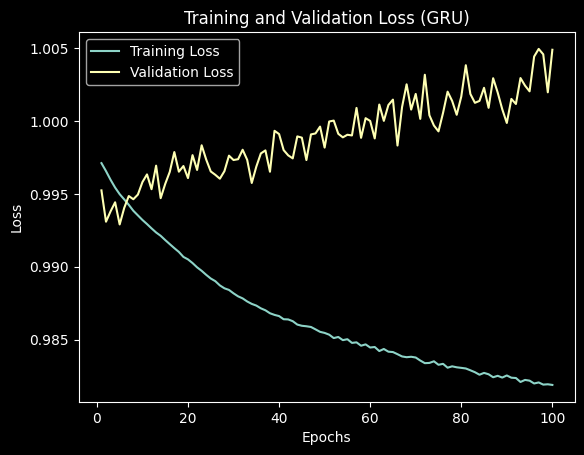

In [61]:
# Extract loss values from the history object
training_loss_GRU = history_GRU.history['loss']
validation_loss_GRU = history_GRU.history['val_loss']

# Create a range of epochs for x-axis
epochs = range(1, len(training_loss_GRU) + 1)

# Plot the training and validation loss values
plt.plot(epochs, training_loss_GRU, label='Training Loss')
plt.plot(epochs, validation_loss_GRU, label='Validation Loss')
plt.title('Training and Validation Loss (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
# Define the AGRU model
inputs = Input(shape=(30, 6))
gru = GRU(units=6, return_sequences=True)(inputs)
att = Attention()([gru, gru])
gru = GRU(units=6)(att)
outputs = Dense(1)(gru)

model_AGRU = Model(inputs=inputs, outputs=outputs)

# Compile the model
model_AGRU.compile(optimizer=Adam(learning_rate=1e-3), loss="mean_squared_error")

# Define early stopping criteria
early_stopping_AGRU = EarlyStopping(monitor="loss", patience=20, restore_best_weights=True)

# Train the model
history_AGRU = model_AGRU.fit(
    train_X,
    train_y,
    epochs=100,
    batch_size=len(stocks_code),
    validation_data=(test_X, test_y),
    callbacks=[early_stopping_AGRU],
)

# Evaluate the model
loss = model_AGRU.evaluate(test_X, test_y)
print("Model trained with loss:", loss)

Epoch 1/100


2024-05-11 12:42:30.986453: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2100 num_cores: 88 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 31719424 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1203/1203 [==============================] - ETA: 0s - loss: 0.9982

2024-05-11 12:43:58.902520: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2100 num_cores: 88 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 31719424 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1203/1203 [==============================] - 102s 83ms/step - loss: 0.9982 - val_loss: 0.9966
Epoch 2/100
1203/1203 [==============================] - 98s 81ms/step - loss: 0.9975 - val_loss: 0.9953
Epoch 3/100
1203/1203 [==============================] - 98s 81ms/step - loss: 0.9967 - val_loss: 0.9951
Epoch 4/100
1203/1203 [==============================] - 98s 81ms/step - loss: 0.9960 - val_loss: 0.9949
Epoch 5/100
1203/1203 [==============================] - 97s 81ms/step - loss: 0.9957 - val_loss: 0.9950
Epoch 6/100
1203/1203 [==============================] - 97s 81ms/step - loss: 0.9954 - val_loss: 0.9938
Epoch 7/100
1203/1203 [==============================] - 98s 81ms/step - loss: 0.9952 - val_loss: 0.9936
Epoch 8/100
1203/1203 [==============================] - 97s 81ms/step - loss: 0.9950 - val_loss: 0.9939
Epoch 9/100
1203/1203 [==============================] - 97s 81ms/step - loss: 0.9948 - val_loss: 0.9937
Epoch 10/100
1203/1203 [==============================] - 97s 81ms

2024-05-11 15:28:30.166831: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2100 num_cores: 88 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 31719424 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


29209/29209 [==============================] - 171s 6ms/step - loss: 0.9953
Model trained with loss: 0.995345950126648


In [63]:
# Evaluate the model on test data
y_pred_AGRU_train = model_AGRU.predict(train_X)
y_pred_AGRU_test = model_AGRU.predict(test_X)
y_pred_AGRU_drop = model_AGRU.predict(drop_X)
y_pred_AGRU_backtest = np.concatenate(
    (y_pred_AGRU_test.reshape(-1), y_pred_AGRU_drop.reshape(-1)))
y_pred_AGRU_all = np.concatenate(
    (y_pred_AGRU_train.reshape(-1), y_pred_AGRU_backtest.reshape(-1)))
mse_AGRU_train = mean_squared_error(train_y, y_pred_AGRU_train)
mse_AGRU_test = mean_squared_error(test_y, y_pred_AGRU_test)
print(f"AGRU MSE(train): {mse_AGRU_train}")
print(f"AGRU MSE(test): {mse_AGRU_test}")
# AGRU MSE(train): 0.9896615693578518
# AGRU MSE(test): 0.9960141348406323

     1/118308 [..............................] - ETA: 39:36:27

2024-05-11 15:31:58.841960: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2100 num_cores: 88 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 31719424 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1082/1082 [==============================] - 6s 6ms/step
AGRU MSE(train): 0.990386735227951
AGRU MSE(test): 0.9953434656971614


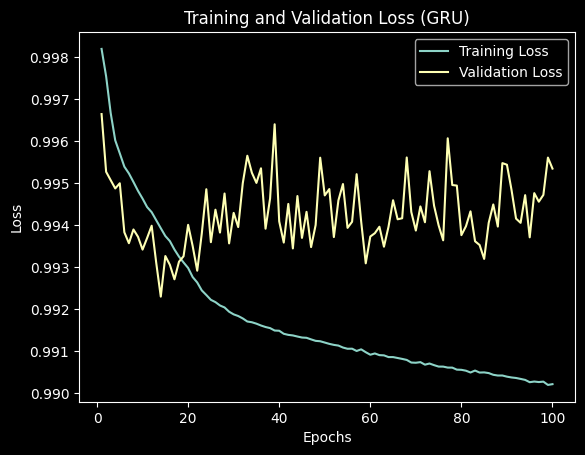

In [64]:
# Extract loss values from the history object
training_loss_AGRU = history_AGRU.history['loss']
validation_loss_AGRU = history_AGRU.history['val_loss']

# Create a range of epochs for x-axis
epochs = range(1, len(training_loss_AGRU) + 1)

# Plot the training and validation loss values
plt.plot(epochs, training_loss_AGRU, label='Training Loss')
plt.plot(epochs, validation_loss_AGRU, label='Validation Loss')
plt.title('Training and Validation Loss (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [65]:
if Main_bactest:
    # Save the numpy array to a file
    np.save("y_pred_AGRU_all.npy", y_pred_AGRU_all)
    np.save("y_pred_AGRU_backtest.npy", y_pred_AGRU_backtest)

In [66]:
if not Online:
    y_pred_AGRU_backtest = np.load('y_pred_AGRU_backtest.npy')
    y_pred_AGRU_all = np.load('y_pred_AGRU_all.npy')

##### Ensemble

In [67]:
def Create_Factor_all(y_pred_all):
    # This is for y_pred_all.
    factor_df = price[["trade_date", "ts_code"]]  # Date and stock
    factor_df.loc[:, "Factor_values"] = y_pred_all  # Add factor values
    factor_df = factor_df.pivot(
        index="trade_date", columns="ts_code", values="Factor_values"
    )  # Transfer to factor dataframe
    return factor_df

def Create_Factor_backtest(y_pred_backtest):
    # This is for y_pred_all.
    factor_df = price.loc[price["trade_date"].isin(date_backtest), :][
        ["trade_date", "ts_code"]
    ]  # Date and stock
    factor_df.loc[:, "Factor_values"] = y_pred_backtest  # Add factor values
    factor_df = factor_df.pivot(
        index="trade_date", columns="ts_code", values="Factor_values"
    )  # Transfer to factor dataframe
    return factor_df

def Create_ICIR_df(factor_DF):
    # This is for y_pred_all.
    IC_series = factor_DF.corrwith(price_return, axis=1, method="spearman")
    ICIR_df = IC_series.shift(1).rolling(60).apply(lambda x: x.mean() / x.std())
    ICIR_df = ICIR_df[
        ICIR_df.index.isin(date_backtest)
    ]  # Select the ICIR in the test date.
    return ICIR_df

In [68]:
# price.loc[price["trade_date"].isin(date_GRU), :]

In [69]:
MLP_factor_all = Create_Factor_all(y_pred_MLP_all)
MLP_factor_backtest = Create_Factor_backtest(y_pred_MLP_backtest)
GBDT_factor_all = Create_Factor_all(y_pred_GBDT_all)
GBDT_factor_backtest = Create_Factor_backtest(y_pred_GBDT_backtest)

AGRU_factor_all = price.loc[price["trade_date"].isin(date_GRU), :].reset_index(
    drop=True
)
AGRU_factor_all = AGRU_factor_all[["trade_date", "ts_code"]]  # Date and stock
AGRU_factor_all.loc[:, "AGRU"] = y_pred_AGRU_all  # Add factor values
AGRU_factor_all = AGRU_factor_all.pivot(
    index="trade_date", columns="ts_code", values="AGRU"
)  # Transfer to factor dataframe
AGRU_factor_backtest = Create_Factor_backtest(y_pred_AGRU_backtest)

# Use abs()
MLP_ICIR = Create_ICIR_df(MLP_factor_all)
MLP_ICIR = MLP_ICIR.abs()

GBDT_ICIR = Create_ICIR_df(GBDT_factor_all)
GBDT_ICIR = GBDT_ICIR.abs()

AGRU_ICIR = Create_ICIR_df(AGRU_factor_all)
AGRU_ICIR = AGRU_ICIR.abs()

In [70]:
GRU_factor_all = price.loc[price["trade_date"].isin(date_GRU), :].reset_index(
    drop=True)
GRU_factor_all = GRU_factor_all[["trade_date", "ts_code"]]  # Date and stock
GRU_factor_all.loc[:, "GRU"] = y_pred_GRU_all  # Add factor values
GRU_factor_all = GRU_factor_all.pivot(
    index="trade_date", columns="ts_code", values="GRU")  # Transfer to factor dataframe
GRU_factor_backtest = Create_Factor_backtest(y_pred_GRU_backtest)

When you use the `exec()` function inside a function to dynamically create variables, the variables created using `exec()` will be local to the function by default. This means that they will only exist within the scope of that function and cannot be accessed outside of it.

Here's an example to illustrate this behavior:

```python
def create_variable():
    exec("new_var = 10")
    print("Inside function - new_var:", new_var)

create_variable()

# Trying to access new_var outside the function will result in a NameError
# print("Outside function - new_var:", new_var)
```

In this example:
- The `exec("new_var = 10")` statement creates a variable `new_var` with a value of 10 inside the `create_variable()` function.
- When we try to access `new_var` within the function, it works fine and prints the value.
- However, if you try to access `new_var` outside the function, it will result in a `NameError` because `new_var` is local to the `create_variable()` function and does not exist in the global scope.

If you want to make the dynamically created variables global, you can achieve this by specifying the `globals()` dictionary as the `globals` argument in the `exec()` function. This way, the variables will be created in the global scope.

Here's an example:

```python
def create_global_variable():
    exec("global global_var; global_var = 20", globals())
    print("Inside function - global_var:", global_var)

create_global_variable()

# Accessing global_var outside the function works as it is now a global variable
print("Outside function - global_var:", global_var)
```

In this modified example, `global_var` is created as a global variable using `exec()` with the `globals()` dictionary as an argument. This allows `global_var` to be accessed outside the function as well.

In [71]:
# Ensembling
def Ensemble_ICIR_weight():
    # Ensemble the models based on ICIR weight
    SUM_ICIR = MLP_ICIR + GBDT_ICIR + AGRU_ICIR
    MLP_ratio = MLP_ICIR / SUM_ICIR
    GBDT_ratio = GBDT_ICIR / SUM_ICIR
    AGRU_ratio = AGRU_ICIR / SUM_ICIR

    MLP_weight = MLP_factor_backtest.multiply(MLP_ratio, axis=0)
    GBDT_weight = GBDT_factor_backtest.multiply(GBDT_ratio, axis=0)
    AGRU_weight = AGRU_factor_backtest.multiply(AGRU_ratio, axis=0)

    ICIR_weight = MLP_weight + GBDT_weight + AGRU_weight
    return ICIR_weight
def Ensemble_ICIR_max(*ICIR_df, type_list):
    # Ensemble the models based on max ICIR

    # Concatenate ICIR DataFrames into Combine_df
    # for ICIR in ICIR_df:
    #     Combine_df = pd.concat([Combine_df, ICIR], axis=1)
    Combine_df = pd.concat(ICIR_df, axis=1)
    Combine_df.columns = type_list
    # print(Combine_df)
    Combine_ranks = Combine_df.rank(axis=1, ascending=False)

    # Choose max ICIR and assign it as 1, others as 0
    Keep_df = Combine_ranks.applymap(lambda x: 1 if x == 1 else 0)

    Ensemble_max = pd.DataFrame()
    for TYPE in type_list:
        # Dynamically create variable names using exec()
        keepp = Keep_df[TYPE]
        # Find factor df use globals()
        positionn = globals()[f"{TYPE}_factor_backtest"].where(keepp == 1, 0)
        Ensemble_max = Ensemble_max.add(positionn, fill_value=0)
    return Ensemble_max

In [72]:
Ensemble_max_factor_df = Ensemble_ICIR_max(MLP_ICIR, GBDT_ICIR, AGRU_ICIR,
                                           type_list=["MLP", "GBDT", "AGRU"])

In [73]:
Ensemble_weight_factor_df = Ensemble_ICIR_weight()

In [74]:
MLP_factor_backtest.to_csv("MLP_factor_backtest.csv")
GBDT_factor_backtest.to_csv("GBDT_factor_backtest.csv")
AGRU_factor_backtest.to_csv("AGRU_factor_backtest.csv")
# Ensemble_factor_df.to_csv("Ensemble_factor_df.csv")

In [75]:
Ensemble_weight_factor_df

ts_code,000001.SZ,000002.SZ,000004.SZ,000006.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,000012.SZ,000014.SZ,...,603986.SH,603987.SH,603988.SH,603989.SH,603990.SH,603991.SH,603993.SH,603997.SH,603998.SH,603999.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2023-02-02,-0.084974,-0.122620,0.082956,-0.032659,0.047100,0.007381,0.069992,0.032675,-0.038750,0.005767,...,-0.047213,0.028318,0.132324,-0.082636,0.024441,-0.017558,-0.085124,-0.025661,-0.002804,0.084807
2023-02-03,-0.015973,-0.082300,0.138896,-0.024118,0.043393,0.036859,0.069909,0.044367,-0.045354,0.010322,...,0.011174,0.058462,0.124620,0.023708,0.013725,0.049901,-0.047116,-0.088500,0.046248,0.095969
2023-02-06,-0.024455,-0.057250,0.113928,-0.029968,-0.013138,0.001195,0.082155,0.040800,-0.034954,0.039383,...,0.061524,0.055212,0.110704,0.048204,0.031457,0.051881,-0.018056,0.023076,0.037856,0.095152
2023-02-07,-0.009251,-0.058223,0.113071,-0.009031,0.020563,-0.048087,0.099665,0.041073,-0.057845,0.033178,...,0.002940,0.059709,0.111691,0.042526,0.048511,0.054502,-0.038269,0.008049,0.055401,0.135841
2023-02-08,-0.048651,-0.092150,0.096189,-0.031680,0.077653,-0.098735,0.105067,0.051372,-0.048821,0.050445,...,0.078947,0.053068,0.056417,0.034736,-0.029033,0.058426,-0.021506,0.029621,0.047740,0.096388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-06,-0.070851,-0.148973,0.069778,0.054730,0.024098,0.011314,0.059037,0.095347,0.012543,0.041213,...,-0.134386,0.113669,0.018832,0.095687,0.131723,-0.045696,-0.129160,0.032386,0.036334,0.111921
2024-05-07,0.035742,0.021798,0.025664,0.054123,0.003988,0.026131,0.058411,0.048215,0.038336,0.034812,...,-0.082588,0.070704,0.029638,0.025809,0.076674,-0.003575,-0.022636,0.024917,0.074292,0.099480
2024-05-08,0.005405,-0.117873,0.029572,0.056015,0.105470,0.037566,0.035263,0.091622,0.039314,0.066926,...,0.010202,0.095267,0.048371,0.044888,0.188649,0.025879,-0.107500,0.044924,0.074240,0.073484


In [76]:
if Main_bactest:
    Ensemble_weight_factor_df.to_csv("Ensemble_weight_factor_df.csv")

### Back testing

In [77]:
# Split return rates data
price_return_backtest = price_return.loc[price_return.index.isin(date_backtest), :]
benchmark_return_backtest = benchmark_return.loc[
    benchmark_return.index.isin(date_backtest), :
]
HS_300_backtest = HS_300.loc[HS_300.index.isin(date_backtest), :]["000300.SH"]
CS_500_backtest = CS_500.loc[HS_300.index.isin(date_backtest), :]["000905.SH"]
CS_1000_backtest = CS_1000.loc[HS_300.index.isin(date_backtest), :]["000852.SH"]

price_backtest = price.loc[price["trade_date"].isin(date_backtest), :]
price_X_backtest = price_backtest[X_indexes].values
price_y_backtest = price_backtest[y_index].values

In [78]:
if Main_bactest:
    price_return_backtest.to_csv("price_return_backtest.csv")
    benchmark_return_backtest.to_csv("benchmark_return_backtest.csv")
    HS_300_backtest.to_csv("HS_300_backtest.csv")
    CS_1000_backtest.to_csv("CS_1000_backtest.csv")
    CS_500_backtest.to_csv("CS_500_backtest.csv")

In [79]:
if not Online:
    # price_backtest = pd.read_csv(path + 'price_backtest.csv',
    #                          parse_dates=["trade_date"])
    price_return_backtest = pd.read_csv(path + 'price_return_backtest.csv',
                                    parse_dates=['trade_date'],
                                    index_col="trade_date")

    HS_300_backtest = pd.read_csv(path + 'HS_300_backtest.csv',
                              parse_dates=["trade_date"],
                              index_col="trade_date")
    HS_300_backtest = HS_300_backtest['000300.SH']

    CS_500_backtest = pd.read_csv(path + 'CS_500_backtest.csv',
                              parse_dates=["trade_date"],
                              index_col="trade_date")
    CS_500_backtest = CS_500_backtest['000905.SH']

    CS_1000_backtest = pd.read_csv(path + 'CS_1000_backtest.csv',
                               parse_dates=["trade_date"],
                               index_col="trade_date")
    CS_1000_backtest = CS_1000_backtest['000852.SH']

In [80]:
def Ensure_position(DF):
    # We add a column named 'Monday' and change positions every Monday.
    DF = DF.shift(1)  # Move one step forward to ensure position
    DF["Monday"] = (DF.index.dayofweek == 0).astype(int)  # Shift except Monday

    # Get the columns to shift (all columns except 'Monday')
    cols_to_shift = DF.columns[DF.columns != "Monday"]

    DF.loc[DF["Monday"] == 0, cols_to_shift] = np.nan
    DF.fillna(
        method="ffill", inplace=True
    )  # Forward fill, holing positions for a week.
    DF.fillna(value=0, inplace=True)  # Fill remaining NaN with 0
    return DF

def Layer_Backtest(factor_df, type):
    # layer number
    num_layers = 20

    # Calculte the ranks of factors daily.
    factor_ranks = factor_df.rank(axis=1, ascending=False)

    # The factor ordering is divided into num_layers, each of which allocates funds equally.
    layer_allocation = (factor_ranks // (len(factor_df.columns) / num_layers)).fillna(0)
    layer_allocation

    # import matplotlib.cm as cm

    plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
    plt.figure(figsize=(10, 5))
    plt.axhline(y=1, color="grey", linestyle="--")

    # Define a color map to use for changing colors progressively
    # colors = plt.cm.jet(np.linspace(0, 1, num_layers))

    global profit_long, profit_short
    profit_long = profit_short = None

    def Long_Short(Num_layers, Layer, Profit):
        global profit_long, profit_short
        long_layer = Num_layers - 1
        short_layer = 0
        if Layer == short_layer:
            profit_short = Profit
            # The short profit comes from the decline of the stock.
            profit_short = profit_short.apply(
                lambda x: x + 1 if x == 0 else -x + (1 - 0.0003)
            )
            profit_short = profit_short.cumprod()
            profit_short *= 0.5
        elif Layer == long_layer:
            profit_long = Profit
            profit_long = profit_long.apply(
                lambda x: x + 1 if x == 0 else x + (1 - 0.0003)
            )
            profit_long = profit_long.cumprod()
            profit_long *= 0.5

    Long_position_df = None
    for layer in range(0, num_layers):
        # Ensure holding stocks
        hold_flag_matrix = layer_allocation.mask(layer_allocation != layer, 0).mask(
            layer_allocation == layer, 1
        )
        hold_flag_matrix = Ensure_position(hold_flag_matrix)
        if layer == num_layers - 1:
            Long_position_df = hold_flag_matrix.copy()

        # Delete 'Monday' to fit into yield dataframe.
        del hold_flag_matrix["Monday"]

        # Calculate the sum of each line in turn.
        stock_amount_sum = hold_flag_matrix.sum(axis=1)

        # Calculate the weight of each stock. (Average distribution at the same level)
        weight_allocation = hold_flag_matrix.apply(
            lambda x: x / stock_amount_sum, axis=0
        ).fillna(0)

        # Calculate the daily profit rate. And prepare to calculate cumprod.
        profit = (weight_allocation * price_return_backtest).sum(axis=1)

        # Create Long and Short position
        Long_Short(num_layers, layer, profit)

        # Calculate the daily equity and draw.
        # Using the 'viridis' colormap with a gradient based on layer number
        colors = cm.viridis(layer / num_layers)
        profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit.cumprod().plot(label=layer, legend=True, color=colors)

    profit_HS300 = HS_300_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color="r")
    profit_CS500 = CS_500_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color="g")
    profit_CS1000 = CS_1000_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color="b")

    (profit_long + profit_short).plot(color="orange", label="long_short", legend=True)
    plt.title(f"20-Layered Portfolio Equity ({type})")
    plt.legend(title="Layer", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

    return profit_long, Long_position_df

### Ensemble Backtest

In [82]:
# Ensemble_factor_df_a = Ensemble_factor_df[Ensemble_factor_df.index >= "2023-07-01"]

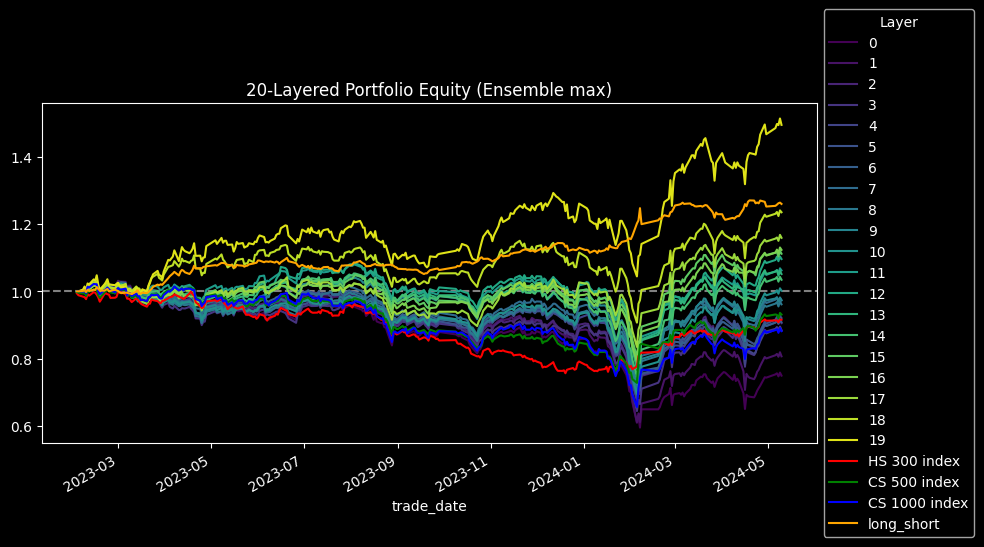

In [83]:
profit_long_Ensemble_max, \
Long_position_df_Ensemble_max = Layer_Backtest(Ensemble_max_factor_df, "Ensemble max")

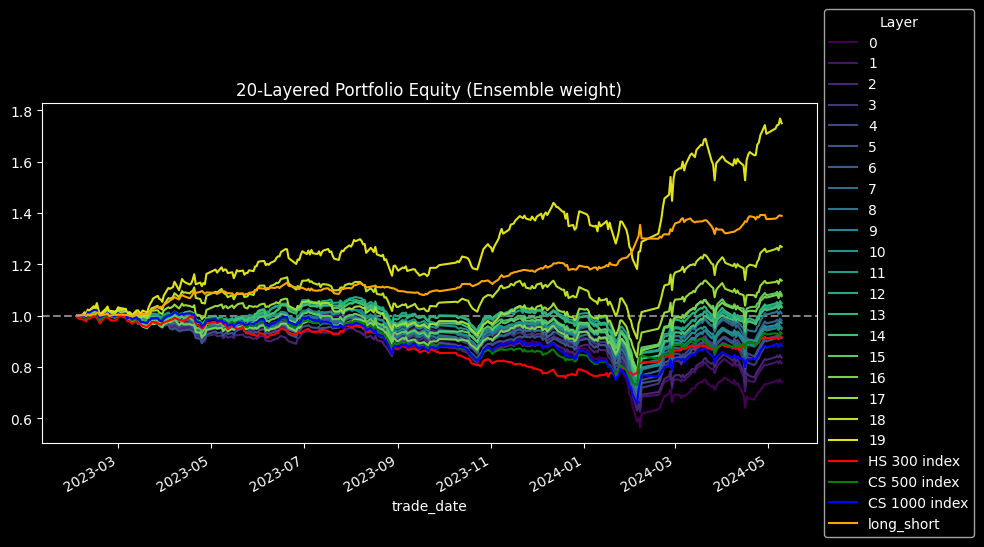

In [84]:
profit_long_Ensemble_weight, \
Long_position_df_Ensemble_weight = Layer_Backtest(Ensemble_weight_factor_df, "Ensemble weight")

In [85]:
Long_position_df_Ensemble_weight.to_csv("Long_position_df_Ensemble_weight.csv")

### MLP Backtest

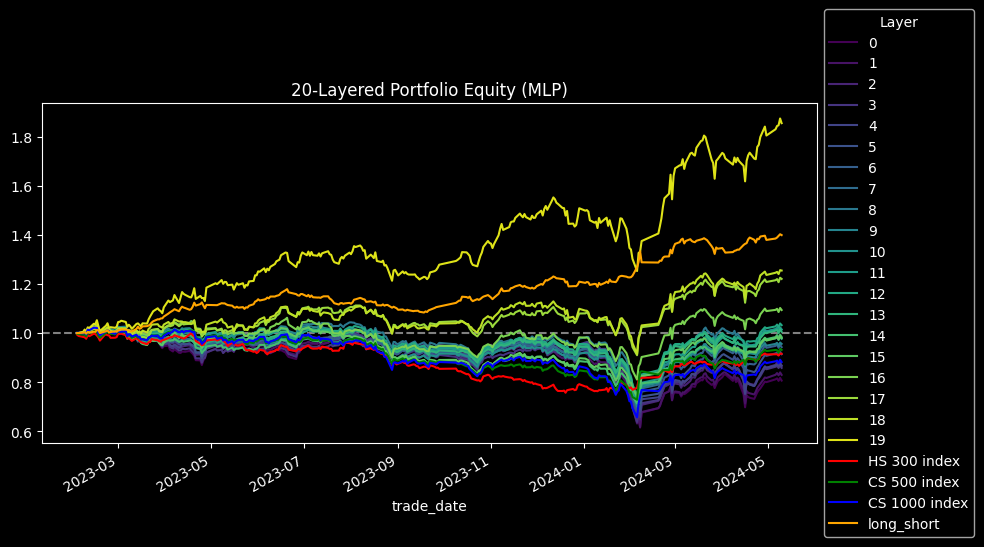

In [86]:
profit_long_MLP, Long_position_df_MLP = Layer_Backtest(MLP_factor_backtest, "MLP")

### GBDT Backtest

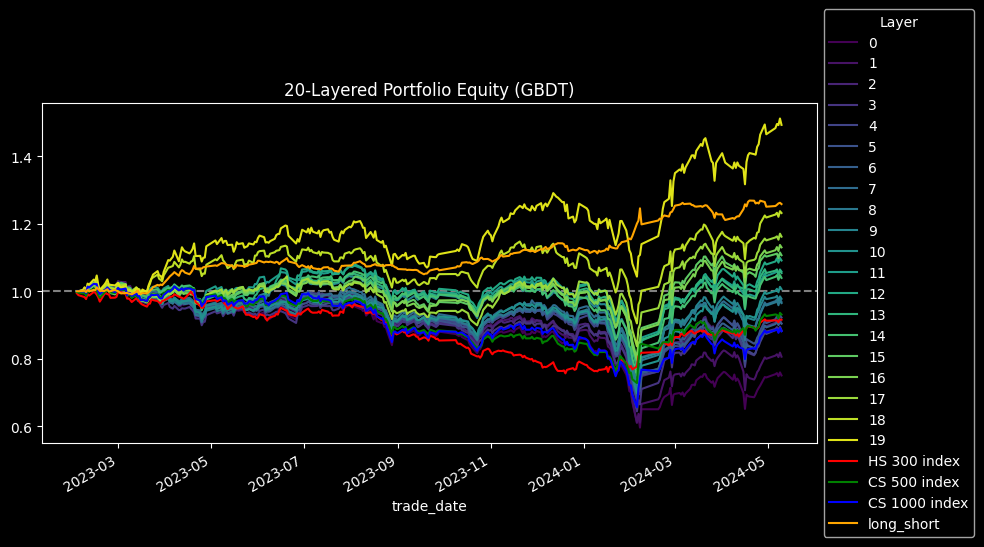

In [87]:
profit_long_GBDT, Long_position_df_GBDT = Layer_Backtest(GBDT_factor_backtest, "GBDT")

### AGRU Backtest

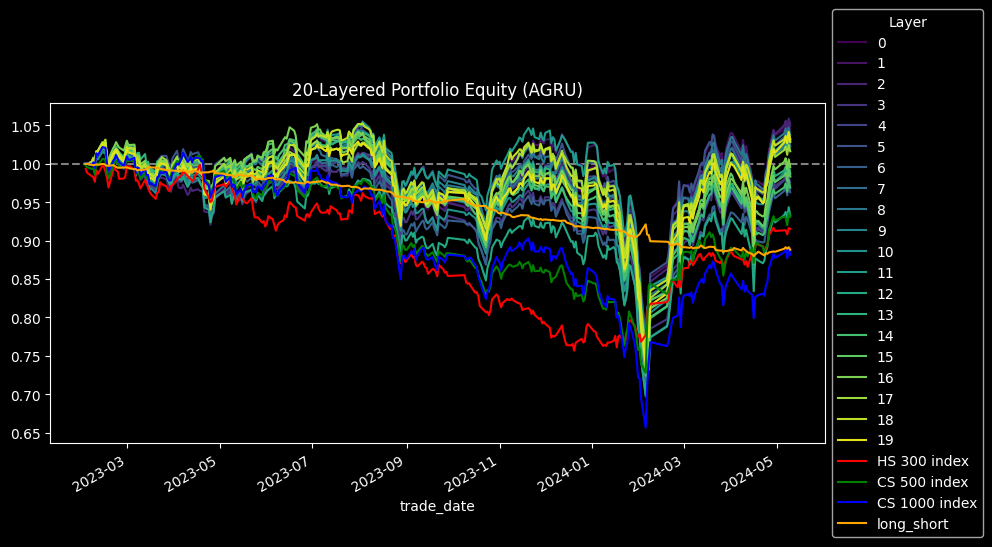

In [88]:
profit_long_AGRU, Long_position_df_AGRU = Layer_Backtest(AGRU_factor_backtest, "AGRU")

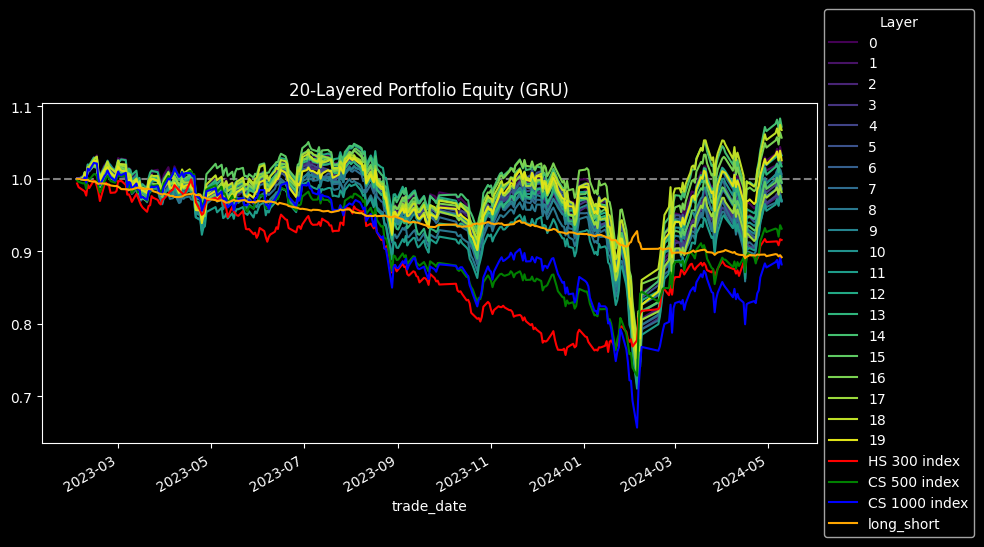

In [89]:
profit_long_GRU, Long_position_df_GRU = Layer_Backtest(GRU_factor_backtest, "GRU")

In [90]:
a = (Ensemble_weight_factor_df.iloc[-5, :].rank(ascending=False) // (3209 / 20)).fillna(0)
list(a[a == 19].index)

['000017.SZ',
 '000063.SZ',
 '000099.SZ',
 '000333.SZ',
 '000422.SZ',
 '000425.SZ',
 '000521.SZ',
 '000532.SZ',
 '000544.SZ',
 '000612.SZ',
 '000651.SZ',
 '000680.SZ',
 '000683.SZ',
 '000737.SZ',
 '000933.SZ',
 '000938.SZ',
 '000949.SZ',
 '000977.SZ',
 '002001.SZ',
 '002035.SZ',
 '002050.SZ',
 '002057.SZ',
 '002080.SZ',
 '002125.SZ',
 '002155.SZ',
 '002156.SZ',
 '002167.SZ',
 '002253.SZ',
 '002367.SZ',
 '002378.SZ',
 '002415.SZ',
 '002455.SZ',
 '002463.SZ',
 '002466.SZ',
 '002475.SZ',
 '002584.SZ',
 '002590.SZ',
 '002601.SZ',
 '002625.SZ',
 '002709.SZ',
 '002735.SZ',
 '002823.SZ',
 '300107.SZ',
 '300122.SZ',
 '300139.SZ',
 '300177.SZ',
 '300181.SZ',
 '300233.SZ',
 '300239.SZ',
 '300252.SZ',
 '300261.SZ',
 '300304.SZ',
 '300364.SZ',
 '300381.SZ',
 '300401.SZ',
 '300411.SZ',
 '300418.SZ',
 '300419.SZ',
 '300476.SZ',
 '300484.SZ',
 '300497.SZ',
 '300505.SZ',
 '300520.SZ',
 '300641.SZ',
 '300735.SZ',
 '600036.SH',
 '600150.SH',
 '600160.SH',
 '600183.SH',
 '600188.SH',
 '600200.SH',
 '6004

### Ensure future position

In [91]:
def Ensure_Future_position_all(factor_df, layer):
    # layer number
    num_layers = 20

    last_day = factor_df.iloc[-1, :]
    # Calculte the ranks of factors daily.
    factor_ranks = last_day.rank(ascending=False)

    # The factor ordering is divided into num_layers, each of which allocates funds equally.
    layer_allocation = (factor_ranks // (len(last_day) / num_layers)).fillna(0)

    selected_stocks = list(layer_allocation[layer_allocation == layer].index)
    return selected_stocks

selected_stocks_main = Ensure_Future_position_all(Ensemble_weight_factor_df, 19)
# In this condition, the long position is in layer 19.
selected_stocks_main

['000063.SZ',
 '000099.SZ',
 '000422.SZ',
 '000521.SZ',
 '000539.SZ',
 '000603.SZ',
 '000610.SZ',
 '000651.SZ',
 '000657.SZ',
 '000721.SZ',
 '000722.SZ',
 '000736.SZ',
 '000737.SZ',
 '000768.SZ',
 '000777.SZ',
 '000899.SZ',
 '000933.SZ',
 '000952.SZ',
 '000960.SZ',
 '000975.SZ',
 '000977.SZ',
 '000988.SZ',
 '000990.SZ',
 '001979.SZ',
 '002001.SZ',
 '002015.SZ',
 '002050.SZ',
 '002078.SZ',
 '002085.SZ',
 '002112.SZ',
 '002125.SZ',
 '002130.SZ',
 '002155.SZ',
 '002156.SZ',
 '002185.SZ',
 '002229.SZ',
 '002236.SZ',
 '002241.SZ',
 '002244.SZ',
 '002271.SZ',
 '002281.SZ',
 '002313.SZ',
 '002339.SZ',
 '002379.SZ',
 '002395.SZ',
 '002413.SZ',
 '002420.SZ',
 '002455.SZ',
 '002463.SZ',
 '002475.SZ',
 '002555.SZ',
 '002590.SZ',
 '002625.SZ',
 '002668.SZ',
 '002712.SZ',
 '002734.SZ',
 '002802.SZ',
 '002805.SZ',
 '002922.SZ',
 '300003.SZ',
 '300034.SZ',
 '300040.SZ',
 '300045.SZ',
 '300073.SZ',
 '300107.SZ',
 '300132.SZ',
 '300139.SZ',
 '300169.SZ',
 '300171.SZ',
 '300175.SZ',
 '300181.SZ',
 '3002

In [92]:
a = all_stocks[all_stocks['ts_code'].isin(selected_stocks_main)]

### Simple Backtest
(Small number of stocks)

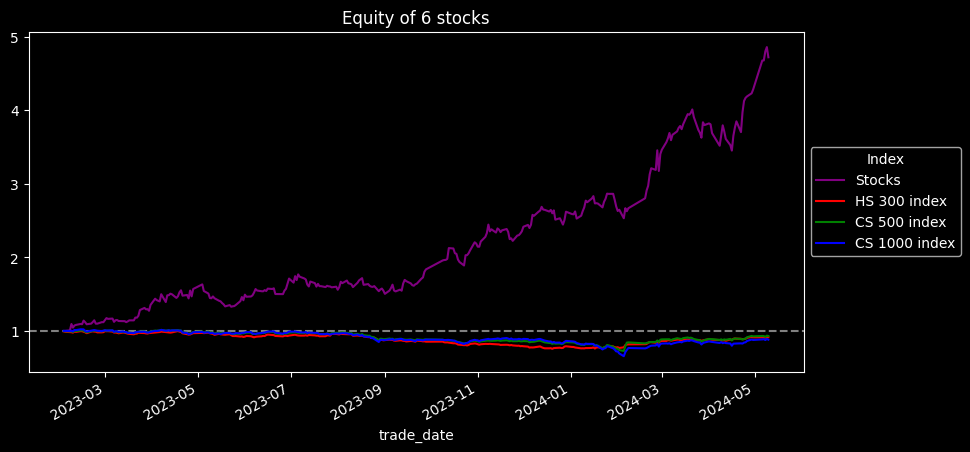

In [93]:
def Simple_Backtest(factor_df, stock_num, Ascending):
    # Calculte the ranks of factors daily.
    factor_ranks = factor_df.rank(axis=1, ascending=Ascending)

    # Create position_df based on top 3 ranks
    position_df = factor_ranks.apply(lambda x: x <= stock_num).astype(int)
    position_df = Ensure_position(position_df)

    # Delete 'Monday' to fit into yield dataframe.
    del position_df["Monday"]

    # Calculate the sum of each line in turn.
    stock_amount_sum = position_df.sum(axis=1)

    # Calculate the weight of each stock. (Average distribution at the same level)
    weight_allocation = position_df.apply(
        lambda x: x / stock_amount_sum, axis=0
    ).fillna(0)

    # Calculate the daily profit rate. And prepare to calculate cumprod.
    profit = (weight_allocation * price_return_backtest).sum(axis=1)

    plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
    plt.figure(figsize=(10, 5))
    plt.axhline(y=1, color="grey", linestyle="--")
    # Calculate the daily equity and draw.
    profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit.cumprod().plot(label="Stocks", legend=True, color="#800080")

    profit_HS300 = HS_300_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color="r")
    profit_CS500 = CS_500_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color="g")
    profit_CS1000 = CS_1000_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color="b")

    plt.title(f"Equity of {stock_num} stocks")
    plt.legend(title="Index", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

Simple_Backtest(Ensemble_weight_factor_df, 6, True)

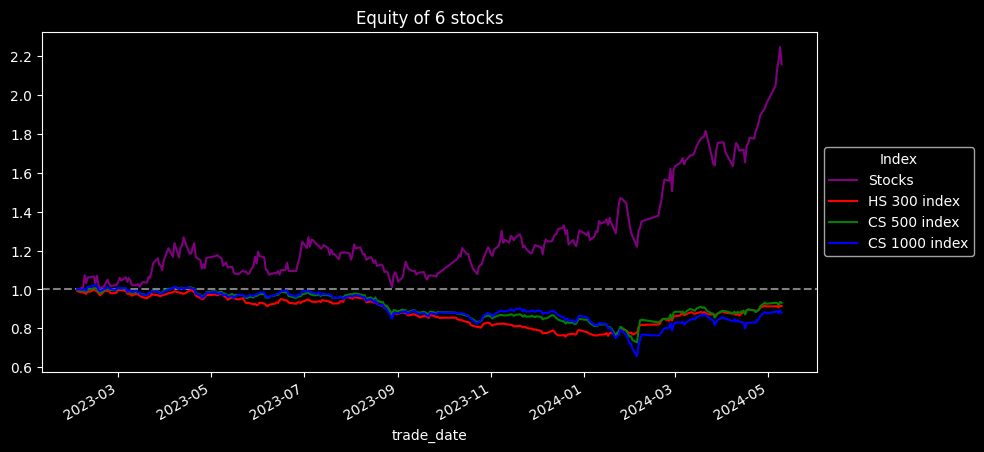

In [94]:
Simple_Backtest(Ensemble_max_factor_df, 6, True)

In [95]:
def Ensure_Future_position_small(factor_df, stock_num, Ascending):
    last_day = factor_df.iloc[-1, :]

    # Calculte the ranks of factors daily.
    factor_ranks = last_day.rank(ascending=Ascending)

    # Create a boolean mask to identify columns where values are between 0 and stock_num - 1
    mask = (factor_ranks > 0) & (factor_ranks <= stock_num)
    print(factor_ranks[mask].sort_values())
    selected_stocks = list(factor_ranks[mask].sort_values().index)
    return selected_stocks

Selected_Stocks = Ensure_Future_position_small(Ensemble_weight_factor_df, 6, True)
Selected_Stocks

ts_code
300447.SZ    1.0
603225.SH    2.0
000899.SZ    3.0
002922.SZ    4.0
300505.SZ    5.0
601233.SH    6.0
Name: 2024-05-10 00:00:00, dtype: float64


['300447.SZ', '603225.SH', '000899.SZ', '002922.SZ', '300505.SZ', '601233.SH']

In [96]:
Trade_Stock_Close_Dict = dict(price.pivot(index="trade_date", 
                                          columns="ts_code", 
                                          values="CLOSE")[Selected_Stocks].iloc[-1, :])
Trade_Stock_Close_Dict

{'300447.SZ': 14.61,
 '603225.SH': 15.56,
 '000899.SZ': 11.75,
 '002922.SZ': 19.25,
 '300505.SZ': 16.29,
 '601233.SH': 15.35}

In [97]:
# Plan A: Buy at open and sell at close
# Plan B:
def Real_trading(Stock_Price_dict, Money, slippage):
    """
    Stamp_duty = 0.0005 (Sell)
    Transfer_fee = 0.00001 (Buy + Sell)
    Commission = 0.00025 (Buy + Sell)(Commission > 5)
    """
    Stock_codes = list(Stock_Price_dict.keys())
    Average_Capital = Money / len(Stock_codes)
    print("Initial Average Capital:", Average_Capital)
    reduce_hand = 0
    position_dict = dict()
    while(1):
        All = 0
        for stock in Stock_codes:
            price = Stock_Price_dict[stock] + slippage
            hands = Average_Capital // (price * 100) - reduce_hand
            Initial = hands * price * 100
            Transfer_fee = Initial * 0.00001
            Commission = Initial * 0.00025 if Initial * 0.00025 >= 5 else 5
            total = Initial + Transfer_fee + Commission
            position_dict[stock] = f"price: {price}, total: {total}, hands: {hands}, fee: {Transfer_fee+Commission}"
            All += Initial + Transfer_fee + Commission
        if All > Money:
            reduce_hand += 1
        else:
            print(f"All init money: {Money}")
            print(f"All position money: {All}")
            break
    return position_dict

In [98]:
Real_trading({'300411.SZ': 15.29,
 '300641.SZ': 19.9,
 '002735.SZ': 13.55,
 '600373.SH': 14.69,
 '002253.SZ': 12.4,
 '002590.SZ': 17.27}, 42758693.25, 0)

Initial Average Capital: 7126448.875
All init money: 42758693.25
All position money: 42757079.95116


{'300411.SZ': 'price: 15.29, total: 7125463.13886, hands: 4659.0, fee: 1852.13886',
 '300641.SZ': 'price: 19.9, total: 7126052.291999999, hands: 3580.0, fee: 1852.292',
 '002735.SZ': 'price: 13.55, total: 7126442.393400001, hands: 5258.0, fee: 1852.3934000000004',
 '600373.SH': 'price: 14.69, total: 7126502.409, hands: 4850.0, fee: 1852.409',
 '002253.SZ': 'price: 12.4, total: 7126892.510400001, hands: 5746.0, fee: 1852.5104000000001',
 '002590.SZ': 'price: 17.27, total: 7125727.2075, hands: 4125.0, fee: 1852.2075'}

In [99]:
Real_trading(Trade_Stock_Close_Dict, 40670535.01, 0)

Initial Average Capital: 6778422.501666666
All init money: 40670535.01
All position money: 40667423.78178


{'300447.SZ': 'price: 14.61, total: 6777879.79068, hands: 4638.0, fee: 1761.7906799999998',
 '603225.SH': 'price: 15.56, total: 6778141.8588, hands: 4355.0, fee: 1761.8588',
 '000899.SZ': 'price: 11.75, total: 6777986.8185, hands: 5767.0, fee: 1761.8185',
 '002922.SZ': 'price: 19.25, total: 6777761.76, hands: 3520.0, fee: 1761.76',
 '300505.SZ': 'price: 16.29, total: 6778401.926399999, hands: 4160.0, fee: 1761.9263999999998',
 '601233.SH': 'price: 15.35, total: 6777251.627399999, hands: 4414.0, fee: 1761.6273999999996'}

In [ ]:
all_stocks[all_stocks['ts_code'].isin(Selected_Stocks)].set_index('ts_code').reindex(Selected_Stocks).reset_index()

In [101]:
def execute_trade(stock_data, initial_capital, tickers):
    portfolio = {ticker: {'Position': 0, 'Value': 0, 'Shares': 0} for ticker in tickers}
    
    for ticker in tickers:
        for i in range(len(stock_data)):
            price = stock_data.loc[i, 'Close']
            signal = stock_data.loc[i, 'Signal']
            
            if signal == 1 and portfolio[ticker]['Position'] == 0:
                available_capital = initial_capital - sum([v['Value'] for v in portfolio.values()])
                shares_to_buy = available_capital // price
                portfolio[ticker]['Position'] = 1
                portfolio[ticker]['Value'] = shares_to_buy * price
                portfolio[ticker]['Shares'] = shares_to_buy
                initial_capital -= portfolio[ticker]['Value']
            
            elif signal == 0 and portfolio[ticker]['Position'] == 1:
                initial_capital += portfolio[ticker]['Value']
                portfolio[ticker]['Position'] = 0
                portfolio[ticker]['Value'] = 0
                portfolio[ticker]['Shares'] = 0
                
    return portfolio

### Indexes

1. RankIC mean(IC mean)
2. ICIR
3. IC winning rate
4. IC t-value
5. Long ROI
6. Long sharp
7. Long retracement
8. Long average weekly turnover rate

In [102]:
def Backtest_Indexes(factor_df, Profit_Long):
    # ICIR
    IC_series = factor_df.corrwith(price_return_backtest, axis=1, method="spearman")
    IC_mean = IC_series.mean()
    print(f"IC mean: {IC_mean}")
    ICIR = IC_series.mean() / IC_series.std()
    print(f"ICIR: {ICIR}")
    IC_series.hist(bins=30)

    # RankIC
    # Create a figure and axis
    _, ax = plt.subplots(figsize=(8, 4))
    # Plot histogram of values on the left side
    ax.bar(IC_series.index, IC_series.values)
    ax.set_title('Histogram of Series Values')
    ax.set_xlabel('Date')
    ax.set_ylabel('RankIC')
    # Create a twin Axes sharing the xaxis
    ax2 = ax.twinx()
    # Plot cumulative line on the right side
    ax2.plot(IC_series.index, IC_series.cumsum(), color='orange')
    ax2.set_ylabel('Cumulative Sum')
    
    # IC winning rate
    IC_winning_rate = sum(1 for ic in IC_series if ic > 0) / len(IC_series)
    print(f"IC winning rate: {IC_winning_rate}")

    t_value = ICIR / sqrt(len(IC_series))
    print(f"IC t-value: {t_value}")

    # Long (Except Short), so `profit_long * 2`
    # profit_long is long equity series.
    Long_equity = Profit_Long * 2
    Long_ROI = (Long_equity[-1]) - 1
    print(f"Long ROI: {Long_ROI}")

    # Max Drawdown
    # Calculate the previous peaks
    previous_peaks = Long_equity.cummax()
    # Calculate the drawdowns
    drawdowns = (Long_equity - previous_peaks) / previous_peaks

    # Find the maximum drawdown and the dates associated with it
    # Convert the index labels to a numeric format
    drawdowns.index = pd.to_numeric(drawdowns.index)
    max_drawdown = drawdowns.min()
    print(f"Max drawdown: {max_drawdown}")
    max_drawdown_start = drawdowns.idxmin()

    # Convert the start and end dates back to the original format if needed
    max_drawdown_start = pd.to_datetime(max_drawdown_start).date()
    print(f"Max drawdown begin date: {max_drawdown_start}")

    plt.show()

IC mean: -0.08554145510041328
ICIR: -0.6937902011055567
IC winning rate: 0.20454545454545456
IC t-value: -0.03953236563001869
Long ROI: 0.4940631081592908
Max drawdown: -0.19170461304780823
Max drawdown begin date: 2024-02-05


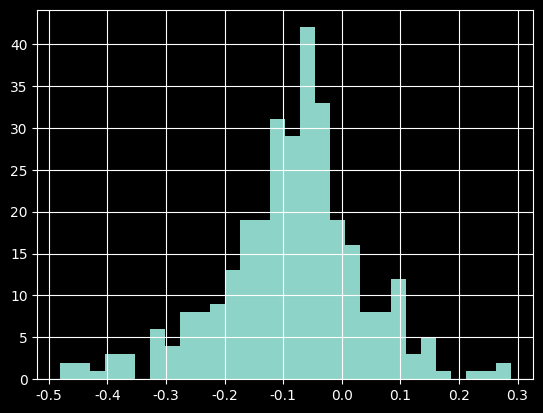

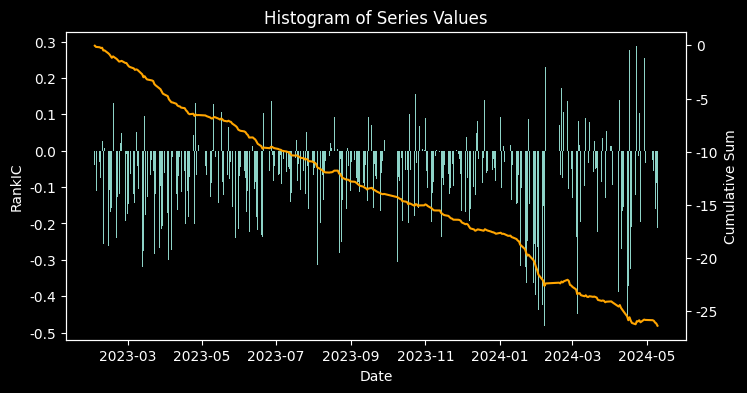

In [103]:
Backtest_Indexes(Ensemble_weight_factor_df, profit_long_Ensemble_max)

IC mean: -0.08189733175267543
ICIR: -0.5647652624595468
IC winning rate: 0.2435064935064935
IC t-value: -0.032180487437134336
Long ROI: 0.8552362769507227
Max drawdown: -0.19322965091495567
Max drawdown begin date: 2024-02-05


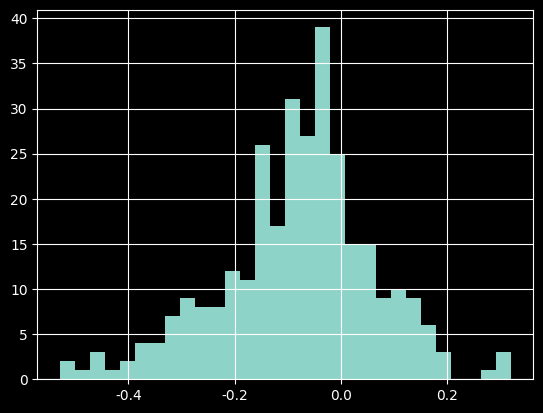

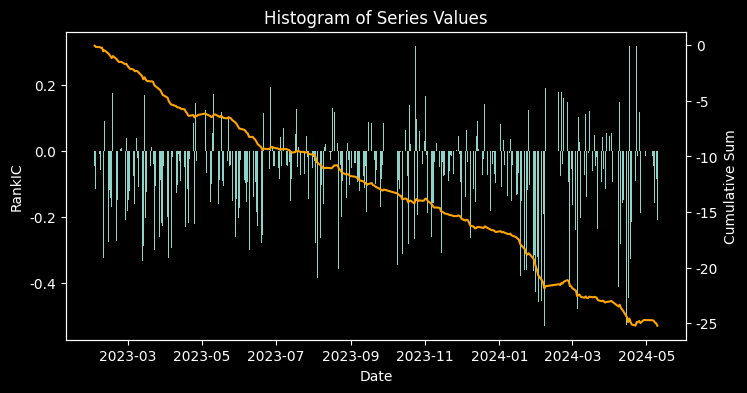

In [104]:
Backtest_Indexes(MLP_factor_backtest, profit_long_MLP)

IC mean: -0.07943715414975488
ICIR: -0.791600624755794
IC winning rate: 0.16233766233766234
IC t-value: -0.04510563176148991
Long ROI: 0.49260465091321426
Max drawdown: -0.19170461304780823
Max drawdown begin date: 2024-02-05


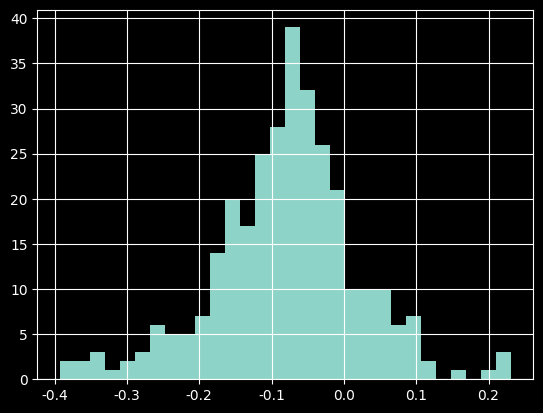

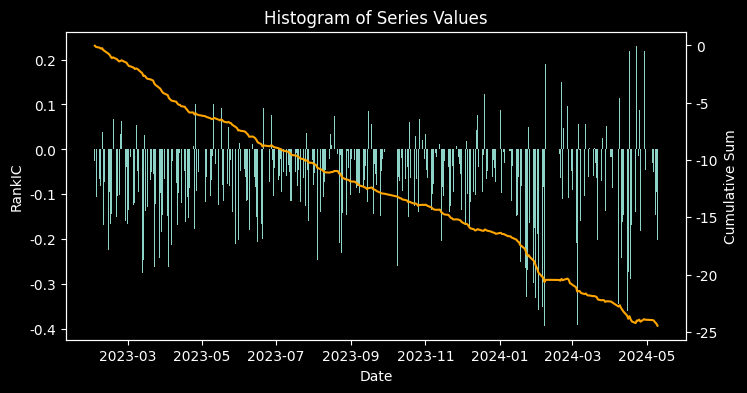

In [105]:
Backtest_Indexes(GBDT_factor_backtest, profit_long_GBDT)

IC mean: -0.00012711445598041182
ICIR: -0.007387336819576834
IC winning rate: 0.5032467532467533
IC t-value: -0.00042093258123024216
Long ROI: 0.028498582510783965
Max drawdown: -0.28130442225724583
Max drawdown begin date: 2024-02-05


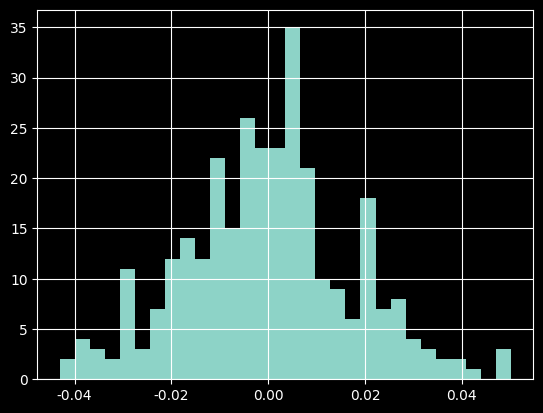

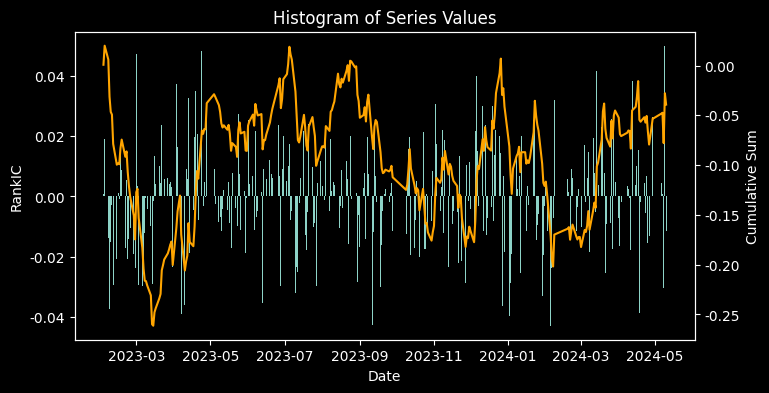

In [106]:
Backtest_Indexes(AGRU_factor_backtest, profit_long_AGRU)

IC mean: 0.0005520887109392528
ICIR: 0.03253522193769797
IC winning rate: 0.5162337662337663
IC t-value: 0.0018538663236311597
Long ROI: 0.0253882358771107
Max drawdown: -0.2690502992717207
Max drawdown begin date: 2024-02-05


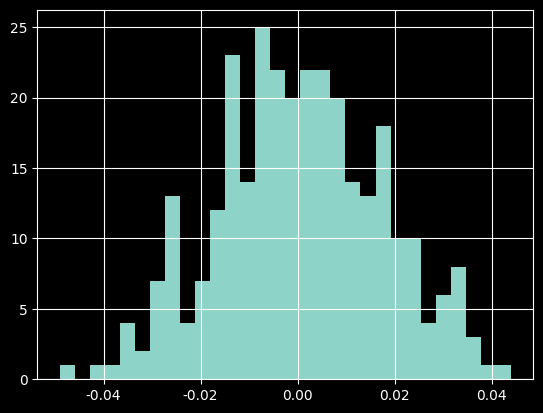

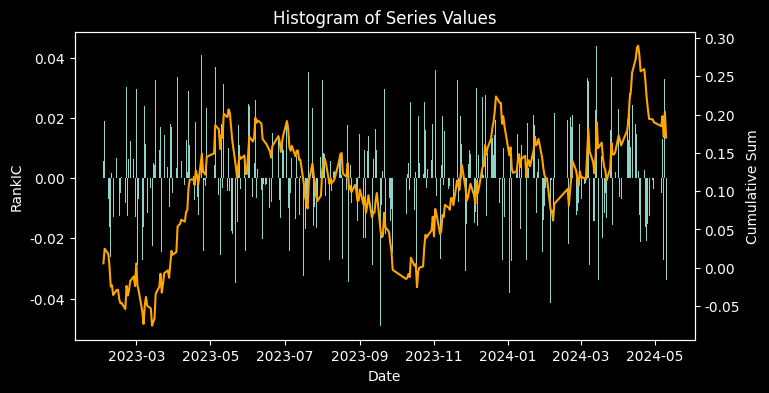

In [107]:
Backtest_Indexes(GRU_factor_backtest, profit_long_GRU)

### Correlation

##### 1. Factor Correlation

In [108]:
def Factor_Correlation(*Factor_df, type_list):
    # Factor cross-sectional correlation
    for i in range(len(Factor_df) - 1):
        temp_df = Factor_df[i]
        for j in range(i + 1, len(Factor_df)):
            temp_df.corrwith(Factor_df[j], axis=1).plot(label=f'{type_list[i]} & {type_list[j]}',
                                                        legend=True)
    plt.title(f"Correlation of Daily Factor Values")
    plt.legend(title="Factors", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

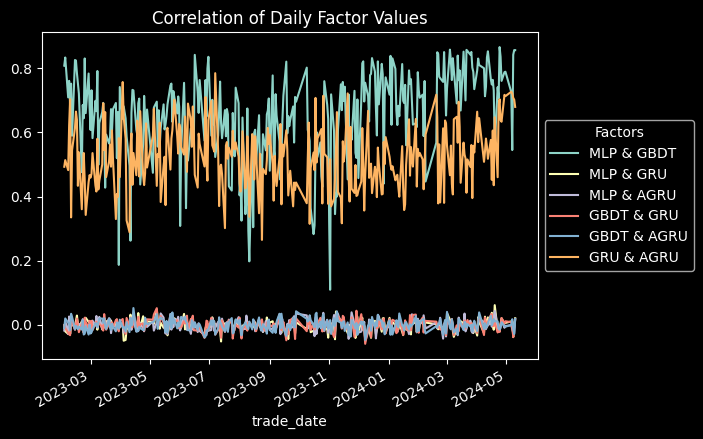

In [109]:
Factor_Correlation(MLP_factor_backtest, 
                   GBDT_factor_backtest, 
                   GRU_factor_backtest,
                   AGRU_factor_backtest,
                   type_list=["MLP", "GBDT", "GRU", "AGRU"])

In Python, `*args` and `**kwargs` are used to pass a variable number of arguments to a function.

- `*args`: The `*args` parameter in a function definition allows you to pass a variable number of positional arguments. When you use `*args` in a function definition, it collects all the positional arguments passed to the function into a tuple. You can then iterate over this tuple to access each argument.

Example:
```python
def my_function(*args):
    for arg in args:
        print(arg)

my_function('apple', 'banana', 'cherry')
```

Output:
```
apple
banana
cherry
```

- `**kwargs`: The `**kwargs` parameter in a function definition allows you to pass a variable number of keyword arguments. When you use `**kwargs` in a function definition, it collects all the keyword arguments passed to the function into a dictionary where the keys are the argument names and the values are the argument values.

Example:
```python
def my_function(**kwargs):
    for key, value in kwargs.items():
        print(f"{key}: {value}")

my_function(fruit='apple', color='red', price=1.00)
```

Output:
```
fruit: apple
color: red
price: 1.00
```

By using `*args` and `**kwargs`, you can create functions that are flexible and can accept a varying number of arguments, both positional and keyword arguments.

##### 2. Average IC Correlation

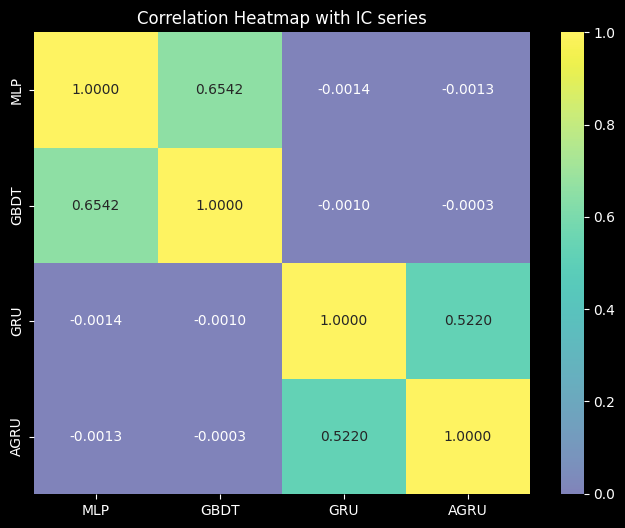

In [111]:
def Average_IC_Correlation(*Factor_df, type_list):
    # Average Factor cross-sectional correlatcolumnsion
    matrix = pd.DataFrame(index=type_list, columns=type_list)
    np.fill_diagonal(matrix.values, 1) # Assign it with unit matrix
    for i in range(len(Factor_df) - 1):
        temp_df = Factor_df[i]
        for j in range(i + 1, len(Factor_df)):
            corr = temp_df.corrwith(Factor_df[j], axis=1).mean()
            # This is a symmetric matrix.
            matrix.iat[i, j] = corr
            matrix.iat[j, i] = corr
    return matrix
Average_IC_matrix = Average_IC_Correlation(
    MLP_factor_backtest,
    GBDT_factor_backtest,
    GRU_factor_backtest,
    AGRU_factor_backtest,
    type_list=["MLP", "GBDT", "GRU", "AGRU"],
)
# Convert data type of Average_IC_matrix to float for heatmap
Average_IC_matrix = Average_IC_matrix.astype(float)

# Create a heatmap
plt.figure(figsize=(8, 6))

# Create a custom color map with reduced brightness based on 'viridis'
viridis_cmap = plt.colormaps.get_cmap('viridis')
new_colors = viridis_cmap(np.linspace(0.2, 1, 256)) ** 0.5  # Adjust the brightness level here
custom_cmap = sns.color_palette(new_colors)

sns.heatmap(Average_IC_matrix, annot=True, cmap=custom_cmap, fmt=".4f")
plt.title('Correlation Heatmap with IC series')
plt.show()

##### 3. IC series Correlation

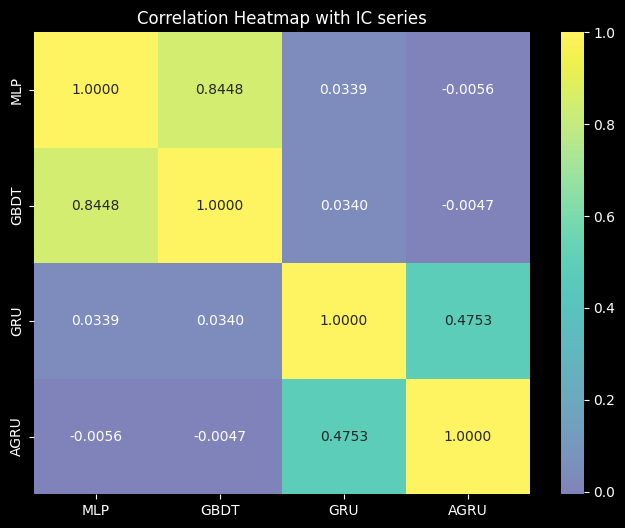

In [112]:
def IC_Correlation(*factor_df, price_return, type_list):
    # Correlation of factor IC series
    Correlation_df = None
    for factor in factor_df:
        Corr = factor.corrwith(price_return, axis=1)
        Correlation_df = pd.concat([Correlation_df, Corr], axis=1)
    # Change the columns to type_list
    Correlation_df.columns = type_list
    return Correlation_df

IC_Correlation_df = IC_Correlation(
    MLP_factor_backtest,
    GBDT_factor_backtest,
    GRU_factor_backtest,
    AGRU_factor_backtest,
    price_return=price_return_backtest,
    type_list=["MLP", "GBDT", "GRU", "AGRU"],
)
IC_Correlation_matrix = IC_Correlation_df.corr()
# Create a heatmap
plt.figure(figsize=(8, 6))

# Create a custom color map with reduced brightness based on 'viridis'
viridis_cmap = plt.colormaps.get_cmap('viridis')
new_colors = viridis_cmap(np.linspace(0.2, 1, 256)) ** 0.5  # Adjust the brightness level here
custom_cmap = sns.color_palette(new_colors)

sns.heatmap(IC_Correlation_matrix, annot=True, cmap=custom_cmap, fmt=".4f")
plt.title('Correlation Heatmap with IC series')
plt.show()